# Tennis PDI - Match Length Prediction Using A Regression Forest

In [1]:
# This is the notebook used in Leo's project to perform experimentations on different models.

In [1]:
### IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

from functools import partial
from datetime import date
from datetime import timedelta
import dateutil.parser


import joblib
import os

In [2]:
# Necessary functions related to match's dates
def get_day_diff(iso_date_cur, iso_date_ref='20220801'):
    """Gets differences between two dates.
    Args:
        iso_date_cur (str): date of the current match's tournament.
        iso_date_ref (str, optional): Defaults to '20220801'.
    """
    datetime_cur = dateutil.parser.isoparse(str(iso_date_cur))
    datetime_ref = dateutil.parser.isoparse(iso_date_ref)
    days_diff = (datetime_ref - datetime_cur).days
    return days_diff

def get_recency_weight(iso_date_cur, Lambda = 365):
    """ returns a weight that gives less importance to old data
    Args: 
        Lambda (int, optional): half-life of the decay. Defaults to 365.
    """
    days_diff = get_day_diff(iso_date_cur)
    recency_weight = (1/2)**(days_diff/Lambda)
    return recency_weight
def get_train_weights(Xtrain, Lambda=1500):
    """Process recency_weights for Xtrain data
    """
    train_weights = list(Xtrain['tourney_date'].map(partial(get_recency_weight, Lambda=Lambda)))
    train_weights = np.array(train_weights)
    return train_weights

def get_former_year_date(iso_date):
    #iso_date is in the following form: 20120825
    former_year = int(str(iso_date)[:4]) - 1
    former_year_date = int(str(former_year) + str(iso_date)[4:])
    return former_year_date

def get_n_former_years_date(iso_date, n_years):
    #iso_date is in the following form: 20120825
    n_former_year = int(str(iso_date)[:4]) - n_years
    n_former_year_date = int(str(n_former_year) + str(iso_date)[4:])
    return n_former_year_date

def get_former_day_date(iso_date):
    #iso_date is in the following form: 20120825
    datetime_cur = dateutil.parser.isoparse(str(iso_date))
    former_day_date_iso = str(datetime_cur - timedelta(days=1))
    former_day_date = former_day_date_iso[:4] + former_day_date_iso[5:7] + former_day_date_iso[8:10]
    return int(former_day_date)

In [ ]:

def update_atp_cat():
    """Uses Jeff Sackmann's github repository to update atp_cat and store it.
    """
    path_to_ATP_matches = "D:/Cours_Centrale/Centrale_G3/projet_rattrapage/PDI_modele_predictif/code_folder/PDI-Tennis/ATP_matches"

    # Deleting the former folder containing data for all atp matches

    try:
        shutil.rmtree(path_to_ATP_matches)
    except OSError:
        print ("Deletion of the directory %s failed" % path_to_ATP_matches)
    else:
        print ("Successfully deleted the directory %s" % path_to_ATP_matches)
    # Creating an empty folder
    try:
        os.mkdir(path_to_ATP_matches)
    except OSError:
        print ("Creation of the directory %s failed" % path_to_ATP_matches)
    else:
        print ("Successfully created the directory %s " % path_to_ATP_matches)
        
        
    # Cloning the Sackmann's whole repository before deleting unnecessary files
    # "Git does not directly support cloning only a specific file or directory from a repository."
    # todo : Check if this is really impossible or not, in order to avoid downloading unnecessary files

    github_url = "https://github.com/JeffSackmann/tennis_atp"
    git.Repo.clone_from(github_url, path_to_ATP_matches)


    # Getting rid of unnecessary files
    def is_standard_atp_file(filename):
        if len(filename) == len("atp_matches_xxxx.csv"):
            first_part = filename[:len("atp_matches_")] == "atp_matches_"
            last_part = filename[-len(".csv"):] == ".csv"
            is_standard_atp_file_bool = first_part and last_part
            return is_standard_atp_file_bool
        else:
            return False
    # todo : problem with the .git file to fix
    # todo : problem with folders to fix 
    path_to_ATP_matches = "D:/Cours_Centrale/Centrale_G3/projet_rattrapage/PDI_modele_predictif/code_folder/PDI-Tennis/ATP_matches"
    for file_name in listdir(path_to_ATP_matches):
        if not is_standard_atp_file(file_name):   
            try:
                os.remove(path_to_ATP_matches + "/" + file_name)
            except OSError:
                print ("Deletion of the file %s failed" % file_name)
            else:
                print ("Successfully deleted the file %s" % file_name)
            #shutil.rmtree(path_to_ATP_matches + "/" + file_name)
            
    # Concatenation of atp csv files in one file
    # todo: check if the paths are correctly handled in the scenario of a remote python virtual environnement
    atp = pd.concat(map(pd.read_csv, glob.glob('ATP_matches/atp_matches_????.csv')))
    atp = atp.drop(['tourney_id', 'draw_size', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'loser_id', 'loser_seed', 'loser_entry'], axis=1)
    atp = atp.dropna(subset=['minutes', 'surface'])
    atp = atp.drop(labels=["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon","w_SvGms", "w_bpSaved", "w_bpFaced", # Data strongly correlated to the target
                            "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon","l_SvGms", "l_bpSaved", "l_bpFaced"], axis=1)
    
    if atp.shape[0] >0: # Then, atp_cat.csv is updated
        try:
            os.remove("atp_cat.csv")
        except OSError:
            print ("Removal of atp_cat.csv failed")
        else:
            atp = atp[atp['tourney_date'] >= 19901231]
            atp.to_csv("atp_cat.csv")
            print ("Successfully updated atp_cat.csv")

perform_update_atp_cat = False
if perform_update_atp_cat:
    update_atp_cat()
    

Successfully deleted the directory D:/Cours_Centrale/Centrale_G3/projet_rattrapage/PDI_modele_predictif/code_folder/PDI-Tennis/ATP_matches
Successfully created the directory D:/Cours_Centrale/Centrale_G3/projet_rattrapage/PDI_modele_predictif/code_folder/PDI-Tennis/ATP_matches 
Deletion of the file .git failed
Successfully deleted the file .gitattributes
Successfully deleted the file atp_matches_amateur.csv
Successfully deleted the file atp_matches_doubles_2000.csv
Successfully deleted the file atp_matches_doubles_2001.csv
Successfully deleted the file atp_matches_doubles_2002.csv
Successfully deleted the file atp_matches_doubles_2003.csv
Successfully deleted the file atp_matches_doubles_2004.csv
Successfully deleted the file atp_matches_doubles_2005.csv
Successfully deleted the file atp_matches_doubles_2006.csv
Successfully deleted the file atp_matches_doubles_2007.csv
Successfully deleted the file atp_matches_doubles_2008.csv
Successfully deleted the file atp_matches_doubles_2009.csv

# Different Preprocessing functions

In [ ]:
# Function to use when no additional features are used
def preprocessing(player_table, scale_x=False, scale_y=False) :
    target='minutes'

    # 1. X, y unscaled
    X = player_table.drop([target], axis=1)
    y = np.asarray(player_table[target])
    y = y.reshape(-1,1)

    xscaler = StandardScaler()
    yscaler = StandardScaler()

    if (scale_x) :
        print("Scaling X...")
        columns_to_scale = ['player_ht', 'opp_ht', 'player_age', 'opp_age',
       'player_rank', 'opp_rank', 'player_rank_points', 'opp_rank_points',
       'rank_diff', 'rank_points_diff']
        xscaler.fit(X[columns_to_scale])
        X[columns_to_scale] = xscaler.transform(X[columns_to_scale])

    if (scale_y) :
        print("Scaling y...")
        yscaler.fit(y)
        y = yscaler.transform(y)

    #display(pd.DataFrame(X).head())
    #display(pd.DataFrame(y).head())

    return X, y, xscaler, yscaler

def preprocess_atp(atp, is_atp_raw=False, train_df_columns=[], scale_x=False):
    
    # if is_atp_raw:
    #     atp = atp.drop(['tourney_id', 'draw_size', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'loser_id', 'loser_seed', 'loser_entry'], axis=1)
    #     atp = atp.dropna(subset=['minutes', 'surface'])
    #     atp = atp.drop(labels=["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon","w_SvGms", "w_bpSaved", "w_bpFaced", # Data strongly correlated to the target
    #                         "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon","l_SvGms", "l_bpSaved", "l_bpFaced"], axis=1)
    
    # We'll drop all of the player's information except his age and rank
    # todo: winner_hand? winner_ioc? -> probably ok. winner ht?
    #atp = atp.drop(labels=["winner_name", "winner_hand", "winner_ht", "winner_ioc"], axis=1)
    # todo: try not dropping winner name
    #atp = atp.drop(labels=["loser_name", "loser_hand", "loser_ht", "loser_ioc"], axis=1)
    # atp = atp.drop(labels=["winner_name", "winner_ioc"], axis=1)
    # atp = atp.drop(labels=["loser_name", "loser_ioc"], axis=1)
    # atp.sort_index(inplace=True) #todo : check what this does achieve
    
    # todo: bien penser à dupliquer les données ou à les shuffles pour que le gagnant ne soit pas toujours à gauche!! 
    
    preprocessed_atp = atp.copy()
    
    #is_train_set = False
    is_train_set = len(train_df_columns) == 0
    
    if is_train_set:
        # Removing potential outliers from the training set    
        list_unusual_score_words = ["w/o", "ret", "def"]
        for unusual_word in list_unusual_score_words:
            preprocessed_atp = preprocessed_atp.reset_index(drop=True)
            bool_array = [unusual_word in str(score).lower() for score in preprocessed_atp["score"]]
            preprocessed_atp = preprocessed_atp.drop(preprocessed_atp[bool_array].index)

        preprocessed_atp = preprocessed_atp[preprocessed_atp.minutes > 35]
        preprocessed_atp = preprocessed_atp[preprocessed_atp.minutes < 665]
    
    
    allow_losing_player_information = False
    
    preprocessed_atp = pd.DataFrame(preprocessed_atp[["minutes", "tourney_date", "surface", "best_of", "winner_hand", "loser_hand", "winner_ht", "loser_ht", "winner_age", "loser_age", "tourney_level", "round", "winner_rank", "loser_rank", "winner_rank_points", "loser_rank_points"]])
    # player1_pf.loc[:,"consecutive"] = atp.loc[:,"consecutive"] #todo: implement win streak
    mirrored_atp = preprocessed_atp.copy() # Only used if allow_losing_player_information is False
    
    # We'll drop all of the player's information except his age and rank
    #preprocessed_atp = preprocessed_atp.drop(labels=["winner_name", "winner_hand", "winner_ht", "winner_ioc"], axis=1)
    preprocessed_atp = preprocessed_atp.rename(columns={"winner_age": "player_age", "winner_ht": "player_ht", "winner_hand": "player_hand", "winner_rank": "player_rank", "winner_rank_points": "player_rank_points",
                                    "loser_hand":"opp_hand", "loser_ht":"opp_ht", "loser_age":"opp_age",
                                    "loser_rank": "opp_rank", "loser_rank_points": "opp_rank_points"})
    #preprocessed_atp["index2"] = preprocessed_atp.index
    #preprocessed_atp["preprocessed_atp"] = "1" # todo : add this column as an index in order to compare classification results? 
    # todo: (there should be similar results for both 0 and 1 values)

    if not allow_losing_player_information:
        #mirrored_atp = mirrored_atp.drop(labels=["loser_name", "loser_hand", "loser_ht", "loser_ioc"], axis=1)
        mirrored_atp = mirrored_atp.rename(columns={"loser_age": "player_age", "loser_ht": "player_ht", "loser_hand": "player_hand", "loser_rank": "player_rank", "loser_rank_points": "player_rank_points",
                                            "winner_hand":"opp_hand", "winner_ht":"opp_ht", "winner_age":"opp_age",
                                            "winner_rank": "opp_rank", "winner_rank_points": "opp_rank_points"})
        #mirrored_atp["index2"] = mirrored_atp.index
        #mirrored_atp["preprocessed_atp"] = "0"
        preprocessed_atp = pd.concat([preprocessed_atp, mirrored_atp])
        # player.drop(list(player.filter(regex = 'Unnamed')), axis = 1, inplace = True)
        
    preprocessed_atp.sort_index(inplace=True)
    # Creating new features
    # To use when features are strongly correlated?
    #preprocessed_atp.loc[:,"rank_diff"] = preprocessed_atp.loc[:,"player_rank"] - preprocessed_atp.loc[:,"opp_rank"]
    #preprocessed_atp.loc[:,"rank_points_diff"] = preprocessed_atp.loc[:,"player_rank_points"] - preprocessed_atp.loc[:,"opp_rank_points"]
    
    # Calculating reasonable relative features which doesn't depend on the player/opponent order.
    # todo: if allow_losing_player_information is False, this adds recurrent information that might be problematic due to curse of dimensionality
    preprocessed_atp["rank_diff"] = np.abs(preprocessed_atp.loc[:,"player_rank"] - preprocessed_atp.loc[:,"opp_rank"])
    preprocessed_atp["rank_points_diff"] = np.abs(preprocessed_atp.loc[:,"player_rank_points"] - preprocessed_atp.loc[:,"opp_rank_points"])
    preprocessed_atp["age_diff"] = np.abs(preprocessed_atp.loc[:,"player_age"] - preprocessed_atp.loc[:,"opp_age"])
    preprocessed_atp["ht_diff"] = np.abs(preprocessed_atp.loc[:,"player_ht"] - preprocessed_atp.loc[:,"opp_ht"])
    
    # Same thing but in order to absolutely avoid using the player/opponent order
    if allow_losing_player_information:
        keep_optimums = True
        if keep_optimums:
            #todo : to be computed
            preprocessed_atp["rank_max"] = np.maximum(preprocessed_atp.loc[:,"player_rank"], preprocessed_atp.loc[:,"opp_rank"])
            preprocessed_atp["rank_points_min"] = np.minimum(preprocessed_atp.loc[:,"player_rank_points"], preprocessed_atp.loc[:,"opp_rank_points"])
            preprocessed_atp["age_max"] = np.maximum(preprocessed_atp.loc[:,"player_age"], preprocessed_atp.loc[:,"opp_age"])
            preprocessed_atp["ht_min"] = np.minimum(preprocessed_atp.loc[:,"player_ht"], preprocessed_atp.loc[:,"opp_ht"])
            # preprocessed_atp["rank_min"] = np.minimum(preprocessed_atp.loc[:,"player_rank"], preprocessed_atp.loc[:,"opp_rank"])
            # preprocessed_atp["rank_points_max"] = np.maximum(preprocessed_atp.loc[:,"player_rank_points"], preprocessed_atp.loc[:,"opp_rank_points"])
            # preprocessed_atp["age_min"] = np.minimum(preprocessed_atp.loc[:,"player_age"], preprocessed_atp.loc[:,"opp_age"])
            # preprocessed_atp["ht_max"] = np.maximum(preprocessed_atp.loc[:,"player_ht"], preprocessed_atp.loc[:,"opp_ht"])
            
            a = 5
        calculate_handers = False
        if calculate_handers: #implementing 3 categories for players' hands : (("R"/"L", "L"/"R", "U"/"R" or "L", "R" or "L"/"U"), ("R"/"R"), ("L"/"L"))
            # todo: check if this works
            preprocessed_atp["left_handers"] = np.logical_and(preprocessed_atp["left_handers"] == "L", preprocessed_atp["left_handers"] == "L")
            preprocessed_atp["right_handers"] = np.logical_and(preprocessed_atp["left_handers"] == "R", preprocessed_atp["left_handers"] == "R")
            preprocessed_atp["diff_handers"] = np.logical_not(np.logical_or(preprocessed_atp["left_handers"], preprocessed_atp["right_handers"]))   
            preprocessed_atp = preprocessed_atp.drop(["player_hand", "opp_hand", 'player_ht', 'opp_ht', 'player_age', 'opp_age', 'opp_rank_points','opp_rank','player_rank', 'player_rank_points'], axis=1)
            preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "tourney_level", "round"])
        else:
            #preprocessed_atp = preprocessed_atp.drop(['player_ht', 'opp_ht', 'player_age', 'opp_age', 'opp_rank_points','opp_rank','player_rank', 'player_rank_points'], axis=1)
            #preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "player_hand", "opp_hand", "tourney_level", "round"])
            preprocessed_atp = preprocessed_atp.drop(["player_hand", "opp_hand", 'player_ht', 'opp_ht', 'player_age', 'opp_age', 'opp_rank_points','opp_rank','player_rank', 'player_rank_points'], axis=1)
            preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "tourney_level", "round"])
        # One-Hot Encoding
        #preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "winner_hand", "loser_hand", "tourney_level", "round"])
        # todo : remove hands
        
    else:
        # One-Hot Encoding
        #preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "winner_hand", "loser_hand", "tourney_level", "round"])
        preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "player_hand", "opp_hand", "tourney_level", "round"])
            
    
    # "player_hand", "opp_hand", 'player_ht', 'opp_ht', 'player_age', 'opp_age',
    # 'opp_rank_points','opp_rank','player_rank', 'player_rank_points', 
    
    
    #todo : check which columns have been dumped (and which should have or musn't have-> surface_Carpet, loser_hand_U
    # needed_columns = ['minutes', 'opp_ht', 'opp_age', 'rank_diff', 'consecutive',
    #     'surface_Clay', 'surface_Grass', 'surface_Hard', 
    #     'best_of_3', 'best_of_5', 'opp_hand_L', 'opp_hand_R', 
    #     'tourney_level_A', 'tourney_level_G', 'tourney_level_M', 
    #     'round_F', 'round_QF', 'round_R128', 'round_R16',
    #     'round_R32', 'round_R64', 'round_RR', 'round_SF']
    
    preprocessed_atp = preprocessed_atp.dropna(axis=0, how='any')
    preprocessed_atp = preprocessed_atp.drop(['best_of_5'], axis=1)

    #print(preprocessed_atp.columns)
    # if is_train_set:
        # if not (set(needed_columns)).issubset(set(preprocessed_atp.columns.tolist())):
            #print("Not enough columns data but still training a model")
            #raise SystemExit(0)    
        # preprocessed_atp = pd.DataFrame(preprocessed_atp, columns=needed_columns)
        # Dropping empty columns
        # preprocessed_atp = preprocessed_atp.dropna(axis=1, how='any')
    
    if not is_train_set:
        preprocessed_atp = pd.DataFrame(preprocessed_atp, columns=train_df_columns)
        preprocessed_atp = preprocessed_atp.fillna(0)
        # todo : fillna: point à surveiller!! 
    
    scale_y = False    

    X, y, xscaler, yscaler = preprocessing(preprocessed_atp, scale_x, scale_y)
    
    # print(y.shape)
    
    return X, y

In [ ]:
# Function to use when additional features are used
def preprocessing(player_table, scale_x=False, scale_y=False) :
    target='minutes'

    # 1. X, y unscaled
    X = player_table.drop([target], axis=1)
    y = np.asarray(player_table[target])
    y = y.reshape(-1,1)

    xscaler = StandardScaler()
    yscaler = StandardScaler()

    if (scale_x) :
        print("Scaling X...")
        columns_to_scale = ['player_ht', 'opp_ht', 'player_age', 'opp_age',
       'player_rank', 'opp_rank', 'player_rank_points', 'opp_rank_points',
       'rank_diff', 'rank_points_diff', 'diff_aces_frequency', 'diff_double_fault_frequency',
        'diff_serve_won_frequency', 'diff_points_won_frequency','diff_completeness', 'diff_advantage_on_serve']
        # todo : to update
        xscaler.fit(X[columns_to_scale])
        X[columns_to_scale] = xscaler.transform(X[columns_to_scale])

    if (scale_y) :
        print("Scaling y...")
        yscaler.fit(y)
        y = yscaler.transform(y)

    #display(pd.DataFrame(X).head())
    #display(pd.DataFrame(y).head())

    return X, y, xscaler, yscaler

def preprocess_atp(atp, is_atp_raw=False, train_df_columns=[], scale_x=False):
    """On considère ici que la table atp contient déjà les informations sur le gagnant contre le perdant:
    final_additional_features = final_additional_features_winner - final_additional_features_loser
    """
    
    # if is_atp_raw:
    #     atp = atp.drop(['tourney_id', 'draw_size', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'loser_id', 'loser_seed', 'loser_entry'], axis=1)
    #     atp = atp.dropna(subset=['minutes', 'surface'])
    #     atp = atp.drop(labels=["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon","w_SvGms", "w_bpSaved", "w_bpFaced", # Data strongly correlated to the target
    #                         "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon","l_SvGms", "l_bpSaved", "l_bpFaced"], axis=1)
    
    # We'll drop all of the player's information except his age and rank
    # todo: winner_hand? winner_ioc? -> probably ok. winner ht?
    #atp = atp.drop(labels=["winner_name", "winner_hand", "winner_ht", "winner_ioc"], axis=1)
    # todo: try not dropping winner name
    #atp = atp.drop(labels=["loser_name", "loser_hand", "loser_ht", "loser_ioc"], axis=1)
    # atp = atp.drop(labels=["winner_name", "winner_ioc"], axis=1)
    # atp = atp.drop(labels=["loser_name", "loser_ioc"], axis=1)
    # atp.sort_index(inplace=True) #todo : check what this does achieve
    
    # todo: bien penser à dupliquer les données ou à les shuffles pour que le gagnant ne soit pas toujours à gauche!! 
    
    preprocessed_atp = atp.copy()
    
    is_train_set = len(train_df_columns) == 0
    
    # todo: vérifier que la table atp utilisée a bien systématiquement subi le prétraitement ci-dessous, et supprimer ensuite les lignes ci-dessous.
    # if is_train_set:
    #     # Removing potential outliers from the training set    
    #     list_unusual_score_words = ["w/o", "ret", "def"]
    #     for unusual_word in list_unusual_score_words:
    #         preprocessed_atp = preprocessed_atp.reset_index(drop=True)
    #         bool_array = [unusual_word in str(score).lower() for score in preprocessed_atp["score"]]
    #         preprocessed_atp = preprocessed_atp.drop(preprocessed_atp[bool_array].index)

    #     preprocessed_atp = preprocessed_atp[preprocessed_atp.minutes > 35]
    #     preprocessed_atp = preprocessed_atp[preprocessed_atp.minutes < 665]
    
    
    allow_losing_player_information = False # todo : vérifier si le "True" peut être utile ou non. Si non, le supprimer.
    
    features_to_keep = ["minutes", "tourney_date", "surface", "best_of", "winner_hand", "loser_hand", "winner_ht",
                        "loser_ht", "winner_age", "loser_age", "tourney_level", "round", "winner_rank", "loser_rank",
                        "winner_rank_points", "loser_rank_points",'diff_aces_frequency', 'diff_double_fault_frequency',
                        'diff_serve_won_frequency', 'diff_points_won_frequency','diff_completeness', 'diff_advantage_on_serve']
    preprocessed_atp = pd.DataFrame(preprocessed_atp[features_to_keep])
    
    # player1_pf.loc[:,"consecutive"] = atp.loc[:,"consecutive"] #todo: implement win streak
    mirrored_atp = preprocessed_atp.copy() # Only used if allow_losing_player_information is False
    
    # We'll drop all of the player's information except his age and rank
    #preprocessed_atp = preprocessed_atp.drop(labels=["winner_name", "winner_hand", "winner_ht", "winner_ioc"], axis=1)
    preprocessed_atp = preprocessed_atp.rename(columns={"winner_age": "player_age", "winner_ht": "player_ht", "winner_hand": "player_hand", "winner_rank": "player_rank", "winner_rank_points": "player_rank_points",
                                    "loser_hand":"opp_hand", "loser_ht":"opp_ht", "loser_age":"opp_age",
                                    "loser_rank": "opp_rank", "loser_rank_points": "opp_rank_points"})
    #preprocessed_atp["index2"] = preprocessed_atp.index
    #preprocessed_atp["preprocessed_atp"] = "1" # todo : add this column as an index in order to compare classification results? 
    # todo: (there should be similar results for both 0 and 1 values)

    if not allow_losing_player_information:
        #mirrored_atp = mirrored_atp.drop(labels=["loser_name", "loser_hand", "loser_ht", "loser_ioc"], axis=1)
        mirrored_atp = mirrored_atp.rename(columns={"loser_age": "player_age", "loser_ht": "player_ht", "loser_hand": "player_hand", "loser_rank": "player_rank", "loser_rank_points": "player_rank_points",
                                            "winner_hand":"opp_hand", "winner_ht":"opp_ht", "winner_age":"opp_age",
                                            "winner_rank": "opp_rank", "winner_rank_points": "opp_rank_points"})
        get_opposite_features = ['diff_aces_frequency', 'diff_double_fault_frequency',
                                 'diff_serve_won_frequency', 'diff_points_won_frequency',
                                 'diff_completeness', 'diff_advantage_on_serve']
        mirrored_atp[get_opposite_features] = -mirrored_atp[get_opposite_features]
        
        #mirrored_atp["index2"] = mirrored_atp.index
        #mirrored_atp["preprocessed_atp"] = "0"
        preprocessed_atp = pd.concat([preprocessed_atp, mirrored_atp])
        # player.drop(list(player.filter(regex = 'Unnamed')), axis = 1, inplace = True)
        
    preprocessed_atp.sort_index(inplace=True)
    # Creating new features
    # To use when features are strongly correlated?
    #preprocessed_atp.loc[:,"rank_diff"] = preprocessed_atp.loc[:,"player_rank"] - preprocessed_atp.loc[:,"opp_rank"]
    #preprocessed_atp.loc[:,"rank_points_diff"] = preprocessed_atp.loc[:,"player_rank_points"] - preprocessed_atp.loc[:,"opp_rank_points"]
    
    # Calculating reasonable relative features which doesn't depend on the player/opponent order.
    # todo: if allow_losing_player_information is False, this adds recurrent information that might be problematic due to curse of dimensionality
    # preprocessed_atp["rank_diff"] = np.abs(preprocessed_atp.loc[:,"player_rank"] - preprocessed_atp.loc[:,"opp_rank"])
    # preprocessed_atp["rank_points_diff"] = np.abs(preprocessed_atp.loc[:,"player_rank_points"] - preprocessed_atp.loc[:,"opp_rank_points"])
    # preprocessed_atp["age_diff"] = np.abs(preprocessed_atp.loc[:,"player_age"] - preprocessed_atp.loc[:,"opp_age"])
    # preprocessed_atp["ht_diff"] = np.abs(preprocessed_atp.loc[:,"player_ht"] - preprocessed_atp.loc[:,"opp_ht"])
    
    preprocessed_atp["rank_diff"] = preprocessed_atp.loc[:,"player_rank"] - preprocessed_atp.loc[:,"opp_rank"]
    preprocessed_atp["rank_points_diff"] = preprocessed_atp.loc[:,"player_rank_points"] - preprocessed_atp.loc[:,"opp_rank_points"]
    #preprocessed_atp["age_diff"] = preprocessed_atp.loc[:,"player_age"] - preprocessed_atp.loc[:,"opp_age"]
    #preprocessed_atp["ht_diff"] = preprocessed_atp.loc[:,"player_ht"] - preprocessed_atp.loc[:,"opp_ht"]
    
    # Same thing but in order to absolutely avoid using the player/opponent order
    if allow_losing_player_information:
        keep_optimums = True
        if keep_optimums:
            #todo : to be computed
            preprocessed_atp["rank_max"] = np.maximum(preprocessed_atp.loc[:,"player_rank"], preprocessed_atp.loc[:,"opp_rank"])
            preprocessed_atp["rank_points_min"] = np.minimum(preprocessed_atp.loc[:,"player_rank_points"], preprocessed_atp.loc[:,"opp_rank_points"])
            preprocessed_atp["age_max"] = np.maximum(preprocessed_atp.loc[:,"player_age"], preprocessed_atp.loc[:,"opp_age"])
            preprocessed_atp["ht_min"] = np.minimum(preprocessed_atp.loc[:,"player_ht"], preprocessed_atp.loc[:,"opp_ht"])
            # preprocessed_atp["rank_min"] = np.minimum(preprocessed_atp.loc[:,"player_rank"], preprocessed_atp.loc[:,"opp_rank"])
            # preprocessed_atp["rank_points_max"] = np.maximum(preprocessed_atp.loc[:,"player_rank_points"], preprocessed_atp.loc[:,"opp_rank_points"])
            # preprocessed_atp["age_min"] = np.minimum(preprocessed_atp.loc[:,"player_age"], preprocessed_atp.loc[:,"opp_age"])
            # preprocessed_atp["ht_max"] = np.maximum(preprocessed_atp.loc[:,"player_ht"], preprocessed_atp.loc[:,"opp_ht"])
            
            a = 5
        calculate_handers = False
        if calculate_handers: #implementing 3 categories for players' hands : (("R"/"L", "L"/"R", "U"/"R" or "L", "R" or "L"/"U"), ("R"/"R"), ("L"/"L"))
            # todo: check if this works
            preprocessed_atp["left_handers"] = np.logical_and(preprocessed_atp["left_handers"] == "L", preprocessed_atp["left_handers"] == "L")
            preprocessed_atp["right_handers"] = np.logical_and(preprocessed_atp["left_handers"] == "R", preprocessed_atp["left_handers"] == "R")
            preprocessed_atp["diff_handers"] = np.logical_not(np.logical_or(preprocessed_atp["left_handers"], preprocessed_atp["right_handers"]))   
            preprocessed_atp = preprocessed_atp.drop(["player_hand", "opp_hand", 'player_ht', 'opp_ht', 'player_age', 'opp_age', 'opp_rank_points','opp_rank','player_rank', 'player_rank_points'], axis=1)
            preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "tourney_level", "round"])
        else:
            #preprocessed_atp = preprocessed_atp.drop(['player_ht', 'opp_ht', 'player_age', 'opp_age', 'opp_rank_points','opp_rank','player_rank', 'player_rank_points'], axis=1)
            #preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "player_hand", "opp_hand", "tourney_level", "round"])
            preprocessed_atp = preprocessed_atp.drop(["player_hand", "opp_hand", 'player_ht', 'opp_ht', 'player_age', 'opp_age', 'opp_rank_points','opp_rank','player_rank', 'player_rank_points'], axis=1)
            preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "tourney_level", "round"])
        # One-Hot Encoding
        #preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "winner_hand", "loser_hand", "tourney_level", "round"])
        # todo : remove hands
        
    else:
        # One-Hot Encoding
        #preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "winner_hand", "loser_hand", "tourney_level", "round"])
        preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "player_hand", "opp_hand", "tourney_level", "round"])
            
    
    # "player_hand", "opp_hand", 'player_ht', 'opp_ht', 'player_age', 'opp_age',
    # 'opp_rank_points','opp_rank','player_rank', 'player_rank_points', 
    
    
    #todo : check which columns have been dumped (and which should have or musn't have-> surface_Carpet, loser_hand_U
    # needed_columns = ['minutes', 'opp_ht', 'opp_age', 'rank_diff', 'consecutive',
    #     'surface_Clay', 'surface_Grass', 'surface_Hard', 
    #     'best_of_3', 'best_of_5', 'opp_hand_L', 'opp_hand_R', 
    #     'tourney_level_A', 'tourney_level_G', 'tourney_level_M', 
    #     'round_F', 'round_QF', 'round_R128', 'round_R16',
    #     'round_R32', 'round_R64', 'round_RR', 'round_SF']
    
    preprocessed_atp = preprocessed_atp.dropna(axis=0, how='any')
    #preprocessed_atp = preprocessed_atp.drop(get_opposite_features, axis=1) # échantillon témoin
    preprocessed_atp = preprocessed_atp.drop(['best_of_5','tourney_level_G'], axis=1) #tourney_level_G is too highly correlated to "best_of"
    #print(preprocessed_atp.columns)
    # if is_train_set:
        # if not (set(needed_columns)).issubset(set(preprocessed_atp.columns.tolist())):
            #print("Not enough columns data but still training a model")
            #raise SystemExit(0)    
        # preprocessed_atp = pd.DataFrame(preprocessed_atp, columns=needed_columns)
        # Dropping empty columns
        # preprocessed_atp = preprocessed_atp.dropna(axis=1, how='any')
    
    if not is_train_set:
        preprocessed_atp = pd.DataFrame(preprocessed_atp, columns=train_df_columns)
        preprocessed_atp = preprocessed_atp.fillna(0)
        # todo : fillna: point à surveiller!! 
    
    scale_y = False  

    X, y, xscaler, yscaler = preprocessing(preprocessed_atp, scale_x, scale_y)
    
    # print(y.shape)
    
    return X, y

# Code to process/update additional features

In [2]:
# Getting matches data without deleting features related to the proceeding of the match.

import glob
atp = pd.concat(map(pd.read_csv, glob.glob('ATP_matches/*.csv')))
atp = atp.drop(['tourney_id', 'draw_size', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'loser_id', 'loser_seed', 'loser_entry'], axis=1)
atp = atp.dropna()
#atp = atp[atp['tourney_date'] >= 19901231]
atp = atp[atp['tourney_date'] >= 20050101]
#atp = atp[atp['tourney_date'] >= 20181231]

# Warning: preprocessing data here will affect the test set and eventually yield over-optimistic results.
list_unusual_score_words = ["w/o", "ret", "def"]
for unusual_word in list_unusual_score_words:
    atp = atp.reset_index(drop=True)
    bool_array = [unusual_word in str(score).lower() for score in atp["score"]]
    atp = atp.drop(atp[bool_array].index)

atp = atp[atp.minutes > 35]
atp = atp[atp.minutes < 665]
atp = atp.reset_index(drop=True)
#atp.to_csv("atp_cat_for_hist_features_calculation_lambda_250_2010.csv")
atp.to_csv("atp_cat_for_hist_features_calculation_lambda_730_2005.csv")


In [3]:
atp = pd.read_csv("atp_cat.csv")


In [4]:
atp.columns

Index(['Unnamed: 0', 'tourney_name', 'surface', 'tourney_level',
       'tourney_date', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc',
       'winner_age', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'score', 'best_of', 'round', 'minutes', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

In [3]:
def get_wmeans_against_opp(common_opp, player_atp, weights_list_max):
    """Computes weighted averages for matches of player_atp against common_opp.
    Also computes associated uncertainties.
    Args:
        common_opp (str): name of the common opponent
        player_atp (Dataframe): table of atp matches of the current player
        weights_list_max (_type_): reference recency_weight from the match of player1 against player2

    Returns:
        df_wmeans_against_opp(dict): 1-row resulting averages.
    """
    player1_atp_opp = player_atp[player_atp["opp_name"] == common_opp] # df of atp matches of the current player against the common opponent
    player1_atp_opp = player1_atp_opp.drop(columns=['player_name', 'opp_name','tourney_date'])
    recency_weights_against_opp = player1_atp_opp["recency_weights"].values/weights_list_max # Selection of the weights of the current table
    # These weights are divided by the weight of the current match in order to update them
    wmeans_hist_data_against_opp = np.average(a = player1_atp_opp, weights=recency_weights_against_opp, axis = 0) # Performing a weighted average of the historical data against the common opponent
    df_wmeans_against_opp = dict(zip(player1_atp_opp.columns, wmeans_hist_data_against_opp))
    df_wmeans_against_opp["nb_matches"] = player1_atp_opp.shape[0]
    df_wmeans_against_opp["weights_sum"] = sum(recency_weights_against_opp) # Calculating actual weighted sum, that will be used for uncertainty
    
    return df_wmeans_against_opp


In [4]:
# template for functions:

def get_features(df_wmeans):
    """ Uses df_player to process new features
    Frequencies are calculated per total number of related points rather than per game, contrary to what has been done by Sipko.
    Args:
        df_wmeans(Dataframe): df_wmeans against opp
    Returns:
        df_wmeans(Dataframe): Dataframe with every features calculated for all current player/opponent pairs.
        These features represent the player's performance against the opponent "opp", using historical matches' data.
    """
    # todo : convertir le dataframe en dictionnaire pour faciliter l'accès aux fonctions..
    # todo : le faire plus haut vu qu'on n'a pas vraiment besoin de dataframe d'une seule ligne
    
    
    df_wmeans["player_aces_frequency"] = 0
    df_wmeans["player_double_fault_frequency"] = 0
    is_div_ok = df_wmeans["player_svpt"] != 0 
    df_wmeans["player_aces_frequency"][is_div_ok] = df_wmeans[is_div_ok]["player_ace"] / df_wmeans[is_div_ok]["player_svpt"]
    df_wmeans["player_double_fault_frequency"][is_div_ok] = df_wmeans[is_div_ok]["player_df"] / df_wmeans[is_div_ok]["player_svpt"]   # This feature does not seem necessary but why not
    
    
    df_wmeans["player_first_serve_made_frequency"] = 0
    is_div_ok = df_wmeans["player_svpt"] != 0
    df_wmeans["player_first_serve_made_frequency"][is_div_ok] = df_wmeans[is_div_ok]["player_1stIn"]/df_wmeans[is_div_ok]["player_svpt"]
    
    
    df_wmeans["player_first_serve_won_frequency"] = 0
    is_div_ok = df_wmeans["player_1stIn"] != 0
    df_wmeans["player_first_serve_won_frequency"][is_div_ok] = df_wmeans[is_div_ok]["player_1stWon"]/df_wmeans[is_div_ok]["player_1stIn"]
    
    
    df_wmeans["player_second_serve_won_frequency"] = 0 
    is_div_ok = (df_wmeans["player_svpt"] - df_wmeans["player_1stIn"]) != 0 
    df_wmeans["player_second_serve_won_frequency"][is_div_ok] = df_wmeans[is_div_ok]["player_2ndWon"] / (df_wmeans[is_div_ok]["player_svpt"] - df_wmeans[is_div_ok]["player_1stIn"])
    
    
    df_wmeans["player_serve_won_frequency"]= df_wmeans["player_first_serve_won_frequency"] * df_wmeans["player_first_serve_made_frequency"] + df_wmeans["player_second_serve_won_frequency"] * (1 - df_wmeans["player_first_serve_made_frequency"])
    
    
    df_wmeans["player_point_return_won_frequency"] = 0
    is_div_ok = df_wmeans["opp_svpt"] != 0
    df_wmeans["player_point_return_won_frequency"][is_div_ok] = (df_wmeans[is_div_ok]["opp_svpt"] - df_wmeans[is_div_ok]["opp_1stWon"] - df_wmeans[is_div_ok]["opp_2ndWon"])/df_wmeans[is_div_ok]["opp_svpt"]
    
    
    df_wmeans["opp_point_return_won_frequency"] = 0
    is_div_ok = df_wmeans["player_svpt"] != 0
    df_wmeans["opp_point_return_won_frequency"][is_div_ok] = (df_wmeans[is_div_ok]["player_svpt"] - df_wmeans[is_div_ok]["player_1stWon"] - df_wmeans[is_div_ok]["player_2ndWon"])/df_wmeans[is_div_ok]["player_svpt"]
    
    
    df_wmeans["player_points_won_frequency"] = 0
    is_div_ok = (df_wmeans["player_svpt"] + df_wmeans["opp_svpt"]) != 0
    df_wmeans["player_points_won_frequency"][is_div_ok] = (((df_wmeans[is_div_ok]["player_1stWon"] + df_wmeans[is_div_ok]["player_2ndWon"]) + (df_wmeans[is_div_ok]["opp_svpt"] - df_wmeans[is_div_ok]["opp_1stWon"] - df_wmeans[is_div_ok]["opp_2ndWon"])) / (df_wmeans[is_div_ok]["player_svpt"] + df_wmeans[is_div_ok]["opp_svpt"]))
    
    df_wmeans["player_completeness"] = df_wmeans["player_serve_won_frequency"] * df_wmeans["player_point_return_won_frequency"]
    df_wmeans["player_advantage_on_serve"] = df_wmeans["player_serve_won_frequency"] - df_wmeans["opp_point_return_won_frequency"] # Most important feature according to Sipko

    return df_wmeans


In [22]:

# Processing Additional Features using the Common Opponents paradigm

register_dataframe = False
if register_dataframe:
    import xlsxwriter as xls
    workbook = xls.Workbook('hist_features_lambda_730_2005_2.xlsx')
    worksheet = workbook.add_worksheet()
    
hide_SettingWithCopyWarning = True
if hide_SettingWithCopyWarning:
    pd.options.mode.chained_assignment = None

# On crée de bons indices pour cette table nettoyée (atp)
atp = atp.reset_index(drop=True)
# recency_weights_atp = get_train_weights(atp, Lambda=250)
recency_weights_atp = get_train_weights(atp, Lambda=730)
atp["recency_weights"] = recency_weights_atp
#atp = atp.head(1000).reset_index(drop=True)

# On crée une table avec les matchs en doublons, dont on se servira de la façon suivante:
# Joueur étudié en joueur1 et common opponent en joueur 2

preprocessed_atp = atp.copy() # preprocessed atp correspond à la table utilisant les doublons
preprocessed_atp = preprocessed_atp[["winner_name","loser_name", "w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon","w_SvGms", "w_bpSaved", "w_bpFaced", "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon","l_SvGms", "l_bpSaved", "l_bpFaced", "tourney_date"]
]
mirrored_atp = preprocessed_atp.copy() # La table destinée à inverser l'ordre des joueurs

preprocessed_atp = preprocessed_atp.rename(columns={"winner_name":"player_name", "loser_name":"opp_name"})
preprocessed_atp = preprocessed_atp.rename(columns={"w_ace":"player_ace", "w_df":"player_df", "w_svpt":"player_svpt", "w_1stIn":"player_1stIn", "w_1stWon":"player_1stWon", "w_2ndWon":"player_2ndWon","w_SvGms":"player_SvGms", "w_bpSaved":"player_bpSaved", "w_bpFaced":"player_bpFaced"})
preprocessed_atp = preprocessed_atp.rename(columns={"l_ace":"opp_ace", "l_df":"opp_df", "l_svpt":"opp_svpt", "l_1stIn":"opp_1stIn", "l_1stWon":"opp_1stWon", "l_2ndWon":"opp_2ndWon","l_SvGms":"opp_SvGms", "l_bpSaved":"opp_bpSaved", "l_bpFaced":"opp_bpFaced"})
mirrored_atp = mirrored_atp.rename(columns={"loser_name":"player_name", "winner_name":"opp_name"})
mirrored_atp = mirrored_atp.rename(columns={"l_ace":"player_ace", "l_df":"player_df", "l_svpt":"player_svpt", "l_1stIn":"player_1stIn", "l_1stWon":"player_1stWon", "l_2ndWon":"player_2ndWon","l_SvGms":"player_SvGms", "l_bpSaved":"player_bpSaved", "l_bpFaced":"player_bpFaced"})
mirrored_atp = mirrored_atp.rename(columns={"w_ace":"opp_ace", "w_df":"opp_df", "w_svpt":"opp_svpt", "w_1stIn":"opp_1stIn", "w_1stWon":"opp_1stWon", "w_2ndWon":"opp_2ndWon","w_SvGms":"opp_SvGms", "w_bpSaved":"opp_bpSaved", "w_bpFaced":"opp_bpFaced"})

preprocessed_atp = pd.concat([preprocessed_atp, mirrored_atp])
preprocessed_atp.sort_index(inplace=True)

recency_weights = get_train_weights(preprocessed_atp, Lambda=730)
# recency_weights = get_train_weights(preprocessed_atp, Lambda=250)
preprocessed_atp["recency_weights"] = recency_weights


# Pour chaque match (un couple de joueurs), on récupère la liste des common opponents 
players_list = preprocessed_atp["player_name"].unique()
row_idx = 0 # Used to write data to an excel file
for match_idx, match in atp.iterrows():
    if match_idx%1000 == 0:
        print(f"match_idx: {match_idx}")
    try:
        
        player1_name = match["winner_name"]
        player2_name = match["loser_name"]
        tourney_date = match["tourney_date"]
        min_hist_date = get_n_former_years_date(tourney_date, 8) # Not taking into account matches played more than 8 years 
        # before the current match in order to reduce calculation costs.
        weight_current_match = match["recency_weights"]

        # Getting one table per player
        player1_atp = preprocessed_atp[preprocessed_atp["player_name"] == player1_name]
        # todo : implement this filter in a cleaner way not to eliminate matches coming from the same day
        player1_atp = player1_atp[player1_atp["tourney_date"] < tourney_date]
        player1_atp = player1_atp[player1_atp["tourney_date"] >= min_hist_date]
        
        player2_atp = preprocessed_atp[preprocessed_atp["player_name"] == player2_name]
        player2_atp = player2_atp[player2_atp["tourney_date"] < tourney_date]
        player2_atp = player2_atp[player2_atp["tourney_date"] >= min_hist_date]

        # Processing the list of common opponents
        opp_list_1 = player1_atp["opp_name"].unique()
        opp_list_2 = player2_atp["opp_name"].unique()
        common_opp_list = np.intersect1d(opp_list_1, opp_list_2)
        if len(common_opp_list) > 0:

        # Construire les tables des common opponents
        # puis pour  chaque common opponent, pour chacun des deux joueurs, la table associée aux matchs précédents et incluant le common opponent
            dict_p1_wmeans_list = []
            dict_p2_wmeans_list = []
            
            weights_products_per_opponent = [] # Will be used to calculate uncertainty
            leo_uncertainty_measures_per_opponent = []

            for common_opp in common_opp_list:
                # Processing means for each common opponent
                dict_p1_wmeans_against_opp = get_wmeans_against_opp(common_opp=common_opp, player_atp=player1_atp, weights_list_max=weight_current_match)
                dict_p1_wmeans_list.append(dict_p1_wmeans_against_opp)
                
                dict_p2_wmeans_against_opp = get_wmeans_against_opp(common_opp=common_opp, player_atp=player2_atp, weights_list_max=weight_current_match)
                dict_p2_wmeans_list.append(dict_p2_wmeans_against_opp)
                
                # Pre-calculations for future uncertainty calculations
                weights_product = dict_p1_wmeans_against_opp["weights_sum"]*dict_p2_wmeans_against_opp["weights_sum"]
                weights_products_per_opponent.append(weights_product)
                leo_uncertainty_measure = 0.2 + np.log(min(dict_p1_wmeans_against_opp["nb_matches"], dict_p2_wmeans_against_opp["nb_matches"]))
                leo_uncertainty_measures_per_opponent.append(leo_uncertainty_measure)
                
                
            df_p1_wmeans_against_opp = pd.DataFrame(dict_p1_wmeans_list)
            df_p2_wmeans_against_opp = pd.DataFrame(dict_p2_wmeans_list)
            
            features_to_keep = ["player_aces_frequency", "player_double_fault_frequency", 
                                "player_serve_won_frequency","player_points_won_frequency", "player_completeness", 
                                "player_advantage_on_serve"]
            list_frequency_features = ["player_aces_frequency", "player_double_fault_frequency", 
                                "player_serve_won_frequency","player_points_won_frequency", "player_first_serve_made_frequency", 
                                "player_second_serve_won_frequency", "player_point_return_won_frequency", "opp_point_return_won_frequency"]

            # On se sert de ces moyennes pour calculer les features additionnelles pour chaque common opponent 
            df_p1_wmeans = get_features(df_p1_wmeans_against_opp)

            # On filtre les fréquences/pourcentages anormaux
            df_p1_wmeans[list_frequency_features] = df_p1_wmeans[list_frequency_features][df_p1_wmeans[list_frequency_features] >= 0]
            df_p1_wmeans[list_frequency_features] = df_p1_wmeans[list_frequency_features][df_p1_wmeans[list_frequency_features] <= 1]

            # et enfin on fait la moyenne de ces features additionnelles sur tous les common opponents 
            final_additional_features_p1 = df_p1_wmeans[features_to_keep].mean()


            df_p2_wmeans = get_features(df_p2_wmeans_against_opp)
            df_p2_wmeans[list_frequency_features] = df_p2_wmeans[list_frequency_features][df_p2_wmeans[list_frequency_features] >= 0]
            df_p2_wmeans[list_frequency_features] = df_p2_wmeans[list_frequency_features][df_p2_wmeans[list_frequency_features] <= 1]
            final_additional_features_p2 = df_p2_wmeans[features_to_keep].mean()

            
            final_additional_features = final_additional_features_p1 - final_additional_features_p2
            
            # Uncertainty calculation
            # todo : implement another uncertainty measure less harsh
            weights_products_per_opponent_sum = sum(weights_products_per_opponent)
            if weights_products_per_opponent_sum == 0:
                uncertainty_Sipko = np.inf
            else:
                uncertainty_Sipko = 1/weights_products_per_opponent_sum
                
            leo_uncertainty_measures_per_opponent_sum = sum(leo_uncertainty_measures_per_opponent)
            if leo_uncertainty_measures_per_opponent_sum == 0:
                uncertainty_leo = np.inf
            else:
                uncertainty_leo = 1/leo_uncertainty_measures_per_opponent_sum
            
            final_additional_features["original_match_idx"] = match_idx
            final_additional_features["nb_common_opponents"] = len(common_opp_list)
            final_additional_features["Sipko_uncertainty"] = uncertainty_Sipko
            final_additional_features["Leo_uncertainty"] = uncertainty_leo
            
            # Using an Excel document to store processed additional features
            if register_dataframe:
                # final_additional_features_list.append(final_additional_features)
                if row_idx == 0:
                    worksheet.write_row(row_idx, 0, list(final_additional_features.keys()))
                    row_idx += 1
                    worksheet.write_row(row_idx, 0, list(final_additional_features.values))
                    row_idx += 1
                else:
                    worksheet.write_row(row_idx, 0, list(final_additional_features.values))
                    row_idx += 1
                    
                

    except Exception as e: 
        print(e)
        print(f"There was a problem when calculating features for matches with index {match_idx}")
        print("match was:")
        print(match)
    
# df_final_additional_features = pd.DataFrame(final_additional_features_list)
if register_dataframe:
    # df_final_additional_features.to_csv("hist_features_lambda_1000_2_bis.csv")
    workbook.close()


match_idx: 0


KeyboardInterrupt: 

In [9]:
# Merging additional features with original atp data and performing some necessary preprocessing.

atp = pd.read_csv("atp_cat_for_hist_features_calculation_lambda_250_2010.csv")
#atp = pd.read_csv("atp_cat_for_hist_features_calculation_lambda_730_2005.csv")

# df_final_additional_features = pd.read_csv("hist_features_lambda_250_2010_1_csv.csv", sep=';')
df_final_additional_features = pd.read_csv("hist_features_lambda_250_2010_1_csv.csv", decimal=',')
#df_final_additional_features = pd.read_csv("hist_features_lambda_730_2005_1_csv.csv", decimal = ",")
df_final_additional_features = df_final_additional_features.drop(["Unnamed: 0"], axis = 1)
df_final_additional_features = df_final_additional_features.set_index('original_match_idx')
completed_atp = atp.join(df_final_additional_features) # adding additional features to atp.
# todo : verifier que le join est bien fait pour la table des 2005.
completed_atp = completed_atp.rename(columns={'player_aces_frequency':'diff_aces_frequency', 'player_double_fault_frequency':'diff_double_fault_frequency',
                        'player_serve_won_frequency':'diff_serve_won_frequency', 'player_points_won_frequency':'diff_points_won_frequency', 
                        'player_completeness':'diff_completeness',
                        'player_advantage_on_serve':'diff_advantage_on_serve'})
completed_atp = completed_atp.drop(["Unnamed: 0"], axis = 1)

# We can note that Nan values are not dealt with here, but later in the code.

In [ ]:

# Using processed additional features in Random Forest models and estimating the optimal values of uncertainty thresholds

# Note: the original code can be found later in the notebook    

atp_all_players = completed_atp.copy()

validation_instead_of_test = True # Tells whether atp_test represents the validation set or the test set
if validation_instead_of_test:
    max_tourney_date = get_former_year_date(max(atp_all_players['tourney_date'])) # Validation set instead of test set
else:
    max_tourney_date = max(atp_all_players['tourney_date']) # parameter 
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
if validation_instead_of_test:
    atp_test = atp_test[atp_test['tourney_date'] <= max_tourney_date]
print(f"atp_test shape is {atp_test.shape}")
# Filling missing values with random existing data.
# We decided to avoid using mean values in order to reduce the bias induced by the chosen filling method.
atp_test.sample(frac=1, random_state=42)
atp_test = atp_test.fillna(method="ffill")
atp_test = atp_test.fillna(method="bfill")
print(f"There are {atp_test.isna().sum().sum()} Nan values in ATP_test. Should be 0!")

atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]
original_train_set_sire = atp_all_players.shape[0] # Following dropped matches will count as filtered matches
atp_all_players = atp_all_players.dropna() # Handling Nan values for the training set.
atp_all_players = atp_all_players.sort_values(by=["Sipko_uncertainty"])
atp_all_players_save = atp_all_players.copy()

uncertainty_treshold_list = np.linspace(0.2, 1.0, num=17)
#uncertainty_treshold_list = np.linspace(0.4, 1.0, num=13)
#uncertainty_treshold_list = np.linspace(0.6, 0.9, num=7)
validation_score_list = []

for treshold_percentage in uncertainty_treshold_list:
    atp_all_players = atp_all_players_save.copy()

    final_atp_size = int(original_train_set_sire*treshold_percentage) - 1
    atp_all_players = atp_all_players.head(final_atp_size) # Sipko_uncertainty must be sorted!
    max_uncertainty = max(atp_all_players["Sipko_uncertainty"])
    print(f"maximum uncertainty for train set for treshold {treshold_percentage} is {max_uncertainty}")
    atp_all_players.sort_values(by=["tourney_date"])


    # Preprocessing train data
    Xtrain, ytrain = preprocess_atp(atp_all_players)
    # Getting data weigths
    train_weights = get_train_weights(Xtrain, Lambda=250)
    Xtrain = Xtrain.drop(columns=['tourney_date'])

    # Preprocessing test data
    columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
    Xtest, ytest = preprocess_atp(atp_test, is_atp_raw=True, train_df_columns=columns_used_by_model)

    # Perform hyperparameter optimisation if necessary
    
    best_params = {'max_depth': 7, 'min_samples_leaf': 51}
    #best_params = {'n_estimators': 400, 'min_samples_split': 100, 'max_features': 'sqrt', 'max_depth': 60}

    # Fitting the Regressor
    rf_regr = RandomForestRegressor(**best_params, random_state=42)
    # from sklearn.svm import SVR
    # from sklearn.pipeline import make_pipeline
    # from sklearn.preprocessing import StandardScaler
    # rf_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    # rf_regr.fit(Xtrain, ytrain)

    rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)
    # weights should be a list of len len(ytrain)

    # Testing and Computing scores:
    ypred = rf_regr.predict(Xtest)
    ypred_train = rf_regr.predict(Xtrain)
    print(f"Training score : ", rf_regr.score(Xtrain, ytrain))
    print(f"Testing score : ", rf_regr.score(Xtest, ytest))
    print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))
    
    print(f"Score for treshold {treshold_percentage} is {rf_regr.score(Xtest, ytest)}")
    validation_score_list.append(rf_regr.score(Xtest, ytest))
    print("")

    save_model = False
    if save_model:
        path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
        model_number = len(os.listdir(path_to_models))
        joblib.dump(rf_regr, path_to_models + '\model_' + str(model_number))

#test_scores.append(rf_regr.score(Xtest, ytest))
#predictions.append(custom_predict(dtr, scale_x, scale_y, ht, a, rk, c, s, bo, h, l, r))     # ???


atp_test shape is (2543, 49)
There are 0 Nan values in ATP_test. Should be 0!
maximum uncertainty for train set for treshold 0.2 is 0.071218681


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.3651764299322313
Testing score :  0.2563858271467391
Balanced Training score :  0.4542337663904532
Score for treshold 0.2 is 0.2563858271467391

maximum uncertainty for train set for treshold 0.25 is 0.083047525


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.35579666158954126
Testing score :  0.2610308226250946
Balanced Training score :  0.4347215730217885
Score for treshold 0.25 is 0.2610308226250946

maximum uncertainty for train set for treshold 0.30000000000000004 is 0.09636123


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.34418774022618337
Testing score :  0.2602652349242137
Balanced Training score :  0.4158500407861133
Score for treshold 0.30000000000000004 is 0.2602652349242137

maximum uncertainty for train set for treshold 0.35000000000000003 is 0.111961222


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.3438675350660648
Testing score :  0.25591660650111225
Balanced Training score :  0.4054987068392816
Score for treshold 0.35000000000000003 is 0.25591660650111225

maximum uncertainty for train set for treshold 0.4 is 0.131006928


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.3364681837422794
Testing score :  0.2590588583048079
Balanced Training score :  0.3941500204274099
Score for treshold 0.4 is 0.2590588583048079

maximum uncertainty for train set for treshold 0.45 is 0.155931319


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.33231231089444635
Testing score :  0.25683556186147705
Balanced Training score :  0.3879934421087302
Score for treshold 0.45 is 0.25683556186147705

maximum uncertainty for train set for treshold 0.5 is 0.185221492


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.3264939962096223
Testing score :  0.26425697152114624
Balanced Training score :  0.3793500676956576
Score for treshold 0.5 is 0.26425697152114624

maximum uncertainty for train set for treshold 0.55 is 0.223454224


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.321435726892389
Testing score :  0.2689918260329567
Balanced Training score :  0.3747152051903039
Score for treshold 0.55 is 0.2689918260329567

maximum uncertainty for train set for treshold 0.6000000000000001 is 0.279837288


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.3151309730892785
Testing score :  0.2663862556993709
Balanced Training score :  0.3664133707532774
Score for treshold 0.6000000000000001 is 0.2663862556993709

maximum uncertainty for train set for treshold 0.65 is 0.367353438


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.3169073184148551
Testing score :  0.2683437634121296
Balanced Training score :  0.364361174191673
Score for treshold 0.65 is 0.2683437634121296

maximum uncertainty for train set for treshold 0.7 is 0.504618616


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.31411334295517546
Testing score :  0.2717239793017725
Balanced Training score :  0.3603816167399405
Score for treshold 0.7 is 0.2717239793017725

maximum uncertainty for train set for treshold 0.75 is 0.73369732


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.31469764335632544
Testing score :  0.27692084967637687
Balanced Training score :  0.3633262189580082
Score for treshold 0.75 is 0.27692084967637687

maximum uncertainty for train set for treshold 0.8 is 1.221083925


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.3128335844155624
Testing score :  0.28173347687192896
Balanced Training score :  0.35715436856596583
Score for treshold 0.8 is 0.28173347687192896

maximum uncertainty for train set for treshold 0.8500000000000001 is 2.660179063


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.30873192478233036
Testing score :  0.2833756976725448
Balanced Training score :  0.3587818622469603
Score for treshold 0.8500000000000001 is 0.2833756976725448

maximum uncertainty for train set for treshold 0.9000000000000001 is 204.5060906


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.31002208116464114
Testing score :  0.2790590544410605
Balanced Training score :  0.3512040285646254
Score for treshold 0.9000000000000001 is 0.2790590544410605

maximum uncertainty for train set for treshold 0.95 is 2563.679147


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.3106918476693019
Testing score :  0.2817865943624204
Balanced Training score :  0.3519250481193955
Score for treshold 0.95 is 0.2817865943624204

maximum uncertainty for train set for treshold 1.0 is 2563.679147


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\2413014842.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


Training score :  0.3106918476693019
Testing score :  0.2817865943624204
Balanced Training score :  0.3519250481193955
Score for treshold 1.0 is 0.2817865943624204



# Experimenting Models: A single model for the whole database

In [57]:

# Main experimentation field for random forests

# testing set until 07.11:
#atp_test = atp_test[atp_test['tourney_date'] > 20220801] # keeping rows that are not in the training test
# testing set until 17.11:
# atp_test_old = pd.read_csv("ATP_matches/atp_matches_2022.csv")
# atp_test_old = atp_test_old[atp_test_old['tourney_date'] > 20220111] # keeping rows that are not in the training test
# The first date actually is "20220117"

# testing set after 17.11:
#atp_all_players =  pd.read_csv("atp_cat.csv")

atp_all_players = completed_atp.copy()

validation_instead_of_test = False
if validation_instead_of_test:
    max_tourney_date = get_former_year_date(max(atp_all_players['tourney_date'])) # Validation set instead of test set
else:
    max_tourney_date = max(atp_all_players['tourney_date']) # parameter 
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
if validation_instead_of_test:
    atp_test = atp_test[atp_test['tourney_date'] <= max_tourney_date]
# Filling missing values with random existing data.
# We decided to avoid using mean values in order to reduce the bias induced by the chosen filling method.
atp_test.sample(frac=1, random_state=42)
atp_test = atp_test.fillna(method="ffill")
atp_test = atp_test.fillna(method="bfill")

#todo: handle Nan values for the test set.
#atp_all_players =  pd.read_csv("atp_cat.csv")
atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]
atp_all_players = atp_all_players.dropna() # Handling Nan values for the training set.
atp_all_players = atp_all_players.sort_values(by=["Sipko_uncertainty"])
final_atp_size = int(atp_all_players.shape[0]*0.85)
atp_all_players = atp_all_players.head(final_atp_size)
atp_all_players.sort_values(by=["tourney_date"])


# Preprocessing train data
Xtrain, ytrain = preprocess_atp(atp_all_players)
# Getting data weigths
train_weights = get_train_weights(Xtrain, Lambda=250)
Xtrain = Xtrain.drop(columns=['tourney_date'])

# Preprocessing test data
columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
Xtest, ytest = preprocess_atp(atp_test, is_atp_raw=True, train_df_columns=columns_used_by_model)

# Perform hyperparameter optimisation if necessary
perform_Grid_Search = True
if perform_Grid_Search:
    #todo: choose other hyperparameters
    
    # n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 7)]
    # # Number of features to consider at every split
    # max_features = ['auto', 'sqrt']
    # # Maximum number of levels in tree
    # max_depth = [5, 9, 13, 17, 21, 50]
    # max_depth.append(None)
    # max_depth.append(5)
    # #max_depth = [7]
    # # Minimum number of samples required to split a node
    # # min_samples_split = [2, 5, 10]
    # #min_samples_split = [5, 10, 20, 50, 100]
    # # Minimum number of samples required at each leaf node
    # min_samples_leaf = [20 , 50, 100]
    # #min_samples_leaf = [51]
    # # Create the random grid
    # params = {'n_estimators': n_estimators,
    #             'max_features': max_features,
    #             'max_depth': max_depth,
    #             'min_samples_leaf': min_samples_leaf,
    #             #'min_samples_leaf': min_samples_leaf,
    #             }
    
    params = {
        # "criterion":("squared_error", "friedman_mse", "absolute_error", "poisson"), 
        "n_estimators":[100, 200, 400],
        "max_depth":[6,7,8,9,10], 
        "min_samples_leaf":[20,30,40,50,60,70] 
        # "min_weight_fraction_leaf":[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.075, 0.001], 
        # "max_features":np.arange(1, 25)
    }
    # Use the random grid to search for best hyperparameters
            
    #todo : probably 100 by default
    rf_regr = RandomForestRegressor()
    tscv = TimeSeriesSplit(n_splits=2, test_size=int(Xtest.shape[0]*2))
    rf_random_regr_cv = RandomizedSearchCV(rf_regr, params, scoring = "r2", n_iter = 10, cv = tscv, verbose=3, random_state=42, n_jobs = -1)
    # important hyperparameters are cv (for "Cross-Validation") and n_iter (number of combinations to test)
    # The chosen hyperpameters' values are quite low and should be higher for final model selection
    # rf_regr_cv = GridSearchCV(rf_regr, params, scoring="r2", n_jobs=-1, verbose=0, cv=10)
    rf_random_regr_cv.fit(Xtrain, ytrain, sample_weight=train_weights)
    print (f"Mean cross-validated score of the best_estimator: {rf_random_regr_cv.best_score_}")
    best_params = rf_random_regr_cv.best_params_
        
    
    # params = {
    #     # "criterion":("squared_error", "friedman_mse", "absolute_error", "poisson"), 
    #     "max_depth":np.arange(3, 8, 2), 
    #     "min_samples_leaf":np.arange(1, 102, 50), 
    #     # "min_weight_fraction_leaf":[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.075, 0.001], 
    #     # "max_features":np.arange(1, 25)
    # }
    # #todo : add n_estimators as an hyperparameter.
    # #todo : probably 100 by default

    # rf_regr = RandomForestRegressor(random_state=42)
    # rf_regr_cv = GridSearchCV(rf_regr, params, scoring="r2", n_jobs=-1, verbose=0, cv=10)    
    # rf_regr_cv.fit(Xtrain, ytrain)
    # best_params = rf_regr_cv.best_params_
    
else: 
    best_params = {'max_depth': 7, 'min_samples_leaf': 51}
    #best_params = {'n_estimators': 400, 'min_samples_split': 100, 'max_features': 'sqrt', 'max_depth': 60}
print(f"Best parameters: {best_params})")


# Fitting the Regressor
rf_regr = RandomForestRegressor(**best_params, random_state=42)
# from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# rf_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
# rf_regr.fit(Xtrain, ytrain)

rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)
# weights should be a list of len len(ytrain)

# Testing and Computing scores:
ypred = rf_regr.predict(Xtest)
ypred_train = rf_regr.predict(Xtrain)
print(f"Training score : ", rf_regr.score(Xtrain, ytrain))
print(f"Testing score : ", rf_regr.score(Xtest, ytest))
print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))

save_model = True
if save_model:
    path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
    model_number = len(os.listdir(path_to_models))
    joblib.dump(rf_regr, path_to_models + '\model_' + str(model_number))

#test_scores.append(rf_regr.score(Xtest, ytest))
#predictions.append(custom_predict(dtr, scale_x, scale_y, ht, a, rk, c, s, bo, h, l, r))     # ???


Best parameters: {'max_depth': 7, 'min_samples_leaf': 51})


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Training score :  0.24907096531678896
Testing score :  0.16578350109112028


In [35]:

# Code used to get train set and test set for training the Neural Network

# testing set until 07.11:
#atp_test = atp_test[atp_test['tourney_date'] > 20220801] # keeping rows that are not in the training test
# testing set until 17.11:
# atp_test_old = pd.read_csv("ATP_matches/atp_matches_2022.csv")
# atp_test_old = atp_test_old[atp_test_old['tourney_date'] > 20220111] # keeping rows that are not in the training test
# The first date actually is "20220117"

# testing set after 17.11:
#atp_all_players =  pd.read_csv("atp_cat.csv")
atp_all_players = completed_atp.copy()

validation_instead_of_test = False
if validation_instead_of_test:
    max_tourney_date = get_former_year_date(max(atp_all_players['tourney_date'])) # Validation set instead of test set
else:
    max_tourney_date = max(atp_all_players['tourney_date']) # parameter 
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
if validation_instead_of_test:
    atp_test = atp_test[atp_test['tourney_date'] <= max_tourney_date]
print(f"atp_test shape is {atp_test.shape}")
# Filling missing values with random existing data.
# We decided to avoid using mean values in order to reduce the bias induced by the chosen filling method.
atp_test.sample(frac=1, random_state=42)
atp_test = atp_test.fillna(method="ffill")
atp_test = atp_test.fillna(method="bfill")
print(f"There are {atp_test.isna().sum().sum()} Nan values in ATP_test. Should be 0!")

#todo: handle Nan values for the test set.

atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]
original_train_set_sire = atp_all_players.shape[0] # Following dropped matches will count as filtered matches
atp_all_players = atp_all_players.dropna() # Handling Nan values for the training set.
atp_all_players = atp_all_players.sort_values(by=["Sipko_uncertainty"])
atp_all_players_save = atp_all_players.copy()

treshold_percentage = 0.8
validation_score_list = []

atp_all_players = atp_all_players_save.copy()

final_atp_size = int(original_train_set_sire*treshold_percentage) - 1
atp_all_players = atp_all_players.head(final_atp_size) # Sipko_uncertainty must be sorted!
max_uncertainty = max(atp_all_players["Sipko_uncertainty"])
print(f"maximum uncertainty for train set for treshold {treshold_percentage} is {max_uncertainty}")
atp_all_players.sort_values(by=["tourney_date"])


# Preprocessing train data
Xtrain, ytrain = preprocess_atp(atp_all_players, scale_x=True)
# Getting data weigths
train_weights = get_train_weights(Xtrain, Lambda=250)
#Xtrain["train_weights"] = train_weights
Xtrain = Xtrain.drop(columns=['tourney_date'])

# Preprocessing test data
columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
Xtest, ytest = preprocess_atp(atp_test, is_atp_raw=True, train_df_columns=columns_used_by_model, scale_x=True)



    
register_data = False
if register_data:
    Xtrain["target"] = ytrain
    Xtest["target"] = ytest
    Xtrain.to_csv("RNN_train_set_1.csv")
    Xtest.to_csv("RNN_test_set_1.csv")

atp_test shape is (2616, 49)
There are 0 Nan values in ATP_test. Should be 0!
maximum uncertainty for train set for treshold 0.8 is 1.258757174
Scaling X...
Scaling X...


In [17]:
features_to_keep = ['player_ht', 'opp_ht', 'player_age', 'opp_age', 'player_rank',
       'opp_rank', 'player_rank_points', 'opp_rank_points',
       'diff_aces_frequency', 'diff_double_fault_frequency',
       'diff_serve_won_frequency', 'diff_points_won_frequency',
       'diff_completeness', 'diff_advantage_on_serve', 'rank_diff',
       'rank_points_diff', 'surface_Clay', 'surface_Grass', 'surface_Hard',
       'best_of_3', 'tourney_level_A',
       'tourney_level_D', 'tourney_level_F', 'tourney_level_M', 'round_BR',
       'round_F', 'round_QF', 'round_R128', 'round_R16', 'round_R32',
       'round_R64', 'round_RR', 'round_SF']
Xtest = Xtest[features_to_keep]
Xtrain = Xtrain[features_to_keep]

In [18]:
# Using the data above on some Lazy regression models.

from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle
import numpy as np


reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(Xtrain, Xtest, ytrain, ytest)

print(models)

 26%|██▌       | 11/42 [00:51<02:39,  5.14s/it]

GaussianProcessRegressor model failed to execute
Unable to allocate 14.9 GiB for an array with shape (44708, 44708) and data type float64


 38%|███▊      | 16/42 [01:26<02:15,  5.23s/it]

KernelRidge model failed to execute
Unable to allocate 14.9 GiB for an array with shape (44708, 44708) and data type float64


 76%|███████▌  | 32/42 [05:46<02:02, 12.22s/it]

QuantileRegressor model failed to execute
Unable to allocate 14.9 GiB for an array with shape (44708, 44708) and data type float64


100%|██████████| 42/42 [10:13<00:00, 14.60s/it]

                               Adjusted R-Squared           R-Squared  \
Model                                                                   
AdaBoostRegressor                            0.26                0.26   
RandomForestRegressor                        0.24                0.24   
MLPRegressor                                 0.23                0.24   
GradientBoostingRegressor                    0.23                0.24   
LGBMRegressor                                0.23                0.24   
HistGradientBoostingRegressor                0.23                0.24   
ExtraTreesRegressor                          0.23                0.23   
LassoLarsIC                                  0.22                0.23   
Ridge                                        0.22                0.23   
LassoLarsCV                                  0.22                0.23   
RidgeCV                                      0.22                0.23   
BayesianRidge                                0.22  

In [97]:

# Experimentation field for random forests using a single 4-year validation set

# testing set until 07.11:
#atp_test = atp_test[atp_test['tourney_date'] > 20220801] # keeping rows that are not in the training test
# testing set until 17.11:
# atp_test_old = pd.read_csv("ATP_matches/atp_matches_2022.csv")
# atp_test_old = atp_test_old[atp_test_old['tourney_date'] > 20220111] # keeping rows that are not in the training test
# The first date actually is "20220117"

# testing set after 17.11:
atp_all_players = pd.read_csv("atp_cat.csv")

max_tourney_date = max(atp_all_players['tourney_date'])
max_test_tourney_date = get_former_year_date(max_tourney_date)
min_test_tourney_date = get_former_year_date(get_former_year_date(get_former_year_date(get_former_year_date(max_test_tourney_date))))

# A validation set corresponding to all tournaments in a 4-year period.
bool_test_to_keep = np.logical_and(atp_all_players['tourney_date'] >= min_test_tourney_date, atp_all_players['tourney_date'] < max_test_tourney_date)
atp_test = atp_all_players[bool_test_to_keep] # Validation set
atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]

# Preprocessing train data
Xtrain, ytrain = preprocess_atp(atp_all_players)
# Getting data weigths
train_weights = get_train_weights(Xtrain, Lambda=200)
Xtrain = Xtrain.drop(columns=['tourney_date'])

# Preprocessing test data
columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
Xtest, ytest = preprocess_atp(atp_test, is_atp_raw=True, train_df_columns=columns_used_by_model)

# Perform hyperparameter optimisation if necessary
perform_Grid_Search = False
if perform_Grid_Search:
    #todo: choose other hyperparameters
    
    params = {
        # "criterion":("squared_error", "friedman_mse", "absolute_error", "poisson"), 
        "max_depth":np.arange(3, 8, 2), 
        "min_samples_leaf":np.arange(1, 102, 50), 
        # "min_weight_fraction_leaf":[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.075, 0.001], 
        # "max_features":np.arange(1, 25)
    }
    #todo : add n_estimators as an hyperparameter.
    #todo : probably 100 by default

    rf_regr = RandomForestRegressor(random_state=42)
    rf_regr_cv = GridSearchCV(rf_regr, params, scoring="r2", n_jobs=-1, verbose=0, cv=10)    
    rf_regr_cv.fit(Xtrain, ytrain)
    best_params = rf_regr_cv.best_params_
    
else: 
    best_params = {'max_depth': 7, 'min_samples_leaf': 51}
    #best_params = {'n_estimators': 400, 'min_samples_split': 100, 'max_features': 'sqrt', 'max_depth': 60}
print(f"Best parameters: {best_params})")


# Fitting the Regressor
rf_regr = RandomForestRegressor(**best_params, random_state=42)
# from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# rf_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
# rf_regr.fit(Xtrain, ytrain)

rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)
# weights should be a list of len len(ytrain)

# Testing and Computing scores:
ypred = rf_regr.predict(Xtest)
ypred_train = rf_regr.predict(Xtrain)
print(f"Training score : ", rf_regr.score(Xtrain, ytrain))
print(f"Testing score : ", rf_regr.score(Xtest, ytest))
print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))

save_model = False
if save_model:
    path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
    model_number = len(os.listdir(path_to_models))
    joblib.dump(rf_regr, path_to_models + '\model_' + str(model_number))

#test_scores.append(rf_regr.score(Xtest, ytest))
#predictions.append(custom_predict(dtr, scale_x, scale_y, ht, a, rk, c, s, bo, h, l, r))     # ???


Best parameters: {'max_depth': 7, 'min_samples_leaf': 51})


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Training score :  0.24195419970807686
Testing score :  0.23975158489356563
Balanced Training score :  0.43705360058555554


In [23]:
# Template code for using cross-validation scores instead of test scores

# testing set until 07.11:
#atp_test = atp_test[atp_test['tourney_date'] > 20220801] # keeping rows that are not in the training test
# testing set until 17.11:
# atp_test_old = pd.read_csv("ATP_matches/atp_matches_2022.csv")
# atp_test_old = atp_test_old[atp_test_old['tourney_date'] > 20220111] # keeping rows that are not in the training test
# The first date actually is "20220117"

# testing set after 17.11:
atp_all_players = pd.read_csv("atp_cat.csv")
max_tourney_date = max(atp_all_players['tourney_date'])
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]


# Preprocessing train data
Xtrain, ytrain = preprocess_atp(atp_all_players)
# Getting data weigths
train_weights = get_train_weights(Xtrain, Lambda=200)
Xtrain_dates = Xtrain.copy()
Xtrain = Xtrain.drop(columns=['tourney_date'])

# Preprocessing test data
columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
Xtest, ytest = preprocess_atp(atp_test, is_atp_raw=True, train_df_columns=columns_used_by_model)

# Perform hyperparameter optimisation if necessary

best_params = {'max_depth': 7, 'min_samples_leaf': 51}
#best_params = {'n_estimators': 400, 'min_samples_split': 100, 'max_features': 'sqrt', 'max_depth': 60}


# Perform Cross-Validation
tscv = TimeSeriesSplit(n_splits=7, test_size=Xtest.shape[0]) # n_splits last years used
#todo : get exactly one year for validation sets
n_cv = 0
scores = []
for train_index, val_index in tscv.split(Xtrain):
    X_train, X_val = Xtrain.iloc[train_index], Xtrain.iloc[val_index]
    y_train, y_val = ytrain[train_index], ytrain[val_index]
    train_weights_sample = train_weights[train_index]
    
    
    first_date = int(Xtrain_dates.iloc[val_index].iloc[0]["tourney_date"])
    last_date = int(Xtrain_dates.iloc[val_index].iloc[-1]["tourney_date"])
    print("")
    print(f"split number {n_cv} (validation set)")
    print(first_date)
    print(last_date)
    print(len(X_val))
    
    
    rf_regr = RandomForestRegressor(**best_params, random_state=42)
    rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)
   
    print(f"Scores for validation set number {n_cv}:")
    print("Training score : ", rf_regr.score(X_train, y_train))
    ypred_train = rf_regr.predict(X_train)
    print(f"Balanced Training score : ", r2_score(y_train, ypred_train, sample_weight=train_weights_sample))
    val_score = rf_regr.score(X_val, y_val)
    scores.append(val_score)
    print("Testing score : ", rf_regr.score(X_val, y_val))
    
    n_cv += 1
print(f"Mean cross-validation score : {np.mean(scores)}")


save_model = False
if save_model:
    train_weights = get_train_weights(Xtrain_weights, Lambda=selected_lambda)
    # Fitting the Regressor
    rf_regr = RandomForestRegressor(**best_params, random_state=42)
    # from sklearn.svm import SVR
    # from sklearn.pipeline import make_pipeline
    # from sklearn.preprocessing import StandardScaler
    # rf_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)
    # weights should be a list of len len(ytrain)

    # Testing and Computing scores:
    ypred = rf_regr.predict(Xtest)
    ypred_train = rf_regr.predict(Xtrain)
    print(f"Training score : ", rf_regr.score(Xtrain, ytrain))
    print(f"Testing score : ", rf_regr.score(Xtest, ytest))
    print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))

    path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
    model_number = len([name for name in os.listdir(path_to_models) if os.path.isfile(os.path.join(path_to_models, name))])
    joblib.dump(rf_regr, path_to_models + '\model_' + str(model_number))

#test_scores.append(rf_regr.score(Xtest, ytest))
#predictions.append(custom_predict(dtr, scale_x, scale_y, ht, a, rk, c, s, bo, h, l, r))     # ???



split number 0 (validation set)
20130320
20140319
4556


C:\Users\dapol\AppData\Local\Temp\ipykernel_14368\1208854526.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


Scores for validation set number 0:
Training score :  0.2204792901436753
Balanced Training score :  0.359837397041616
Testing score :  0.27746446794878854

split number 1 (validation set)
20140319
20150325
4556


C:\Users\dapol\AppData\Local\Temp\ipykernel_14368\1208854526.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


Scores for validation set number 1:
Training score :  0.24285128316085902
Balanced Training score :  0.3886474625853811
Testing score :  0.29053999906410244

split number 2 (validation set)
20150325
20160829
4556


C:\Users\dapol\AppData\Local\Temp\ipykernel_14368\1208854526.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


Scores for validation set number 2:
Training score :  0.24703365922883846
Balanced Training score :  0.38889780302562593
Testing score :  0.23504309242717325

split number 3 (validation set)
20160829
20170918
4556


C:\Users\dapol\AppData\Local\Temp\ipykernel_14368\1208854526.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


Scores for validation set number 3:
Training score :  0.25313201842335986
Balanced Training score :  0.39999077914775794
Testing score :  0.32242347316017195

split number 4 (validation set)
20170918
20181022
4556


C:\Users\dapol\AppData\Local\Temp\ipykernel_14368\1208854526.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


Scores for validation set number 4:
Training score :  0.2418356936461561
Balanced Training score :  0.4000686717912061
Testing score :  0.2951494141067571

split number 5 (validation set)
20181022
20200113
4556


C:\Users\dapol\AppData\Local\Temp\ipykernel_14368\1208854526.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


Scores for validation set number 5:
Training score :  0.22900591606556342
Balanced Training score :  0.41174658320211477
Testing score :  0.27382754315948377

split number 6 (validation set)
20200113
20210823
4556


C:\Users\dapol\AppData\Local\Temp\ipykernel_14368\1208854526.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


Scores for validation set number 6:
Training score :  0.22794871194442168
Balanced Training score :  0.3746450985498998
Testing score :  0.25555723203903535
Mean cross-validation score : 0.2785721745579303


In [10]:
# Code for estimating optimal sample_weights (using custom cross-validation)

# testing set until 07.11:
#atp_test = atp_test[atp_test['tourney_date'] > 20220801] # keeping rows that are not in the training test
# testing set until 17.11:
# atp_test_old = pd.read_csv("ATP_matches/atp_matches_2022.csv")
# atp_test_old = atp_test_old[atp_test_old['tourney_date'] > 20220111] # keeping rows that are not in the training test
# The first date actually is "20220117"

# testing set after 17.11:
atp_all_players = pd.read_csv("atp_cat.csv")
max_tourney_date = max(atp_all_players['tourney_date'])
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]


Xtrain, ytrain = preprocess_atp(atp_all_players)
# Getting data weigths
#train_weights = get_train_weights(Xtrain, Lambda=1500)
Xtrain_weights = Xtrain.copy()
Xtrain = Xtrain.drop(columns=['tourney_date'])

columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
Xtest, ytest = preprocess_atp(atp_test, is_atp_raw=True, train_df_columns=columns_used_by_model)

# Perform hyperparameter optimisation if necessary

#best_params = {'max_depth': 7, 'min_samples_leaf': 51}
best_params = {'n_estimators': 400, 'min_samples_split': 100, 'max_features': 'sqrt', 'max_depth': 60}



all_lambdas = [200,500,730,1000,2000,5000]
#all_lambdas = [20,50,100,200]
scores_couples = np.zeros((len(all_lambdas),2))

for i,lambdaa in enumerate(all_lambdas):
    
    train_weights = get_train_weights(Xtrain_weights, Lambda=lambdaa)
    
    #todo : add n_estimators as an hyperparameter.
    #todo : probably 100 by default

    tscv = TimeSeriesSplit(n_splits=2, test_size=Xtest.shape[0])
    #todo : get exactly one year for validation sets
    n_cv = 0
    scores = []
    for train_index, val_index in tscv.split(Xtrain):
        X_train, X_val = Xtrain.iloc[train_index], Xtrain.iloc[val_index]
        y_train, y_val = ytrain[train_index], ytrain[val_index]
        train_weights_sample = train_weights[train_index]
        
        rf_regr = RandomForestRegressor(**best_params, random_state=42)
        rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)
        
        print(f"lambda is {lambdaa}")
        print(f"Scores for validation set number {n_cv}:")
        print("Training score : ", rf_regr.score(X_train, y_train))
        ypred_train = rf_regr.predict(X_train)
        print(f"Balanced Training score : ", r2_score(y_train, ypred_train, sample_weight=train_weights_sample))
        val_score = rf_regr.score(X_val, y_val)
        scores.append(val_score)
        print("Testing score : ", rf_regr.score(X_val, y_val))
        
        n_cv += 1
    print(f"Mean cross-validation score for lambda={lambdaa}: {np.mean(scores)}")
    scores_couples[i][0] = lambdaa
    scores_couples[i][1] = np.mean(scores)
    
selected_lambda = scores_couples[np.argmax(scores_couples.T[1])][0]
print(f"selected lambda: {selected_lambda}")

train_weights = get_train_weights(Xtrain_weights, Lambda=selected_lambda)
# Fitting the Regressor
rf_regr = RandomForestRegressor(**best_params, random_state=42)
# from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# rf_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)
# weights should be a list of len len(ytrain)

# Testing and Computing scores:
ypred = rf_regr.predict(Xtest)
ypred_train = rf_regr.predict(Xtrain)
print(f"Training score : ", rf_regr.score(Xtrain, ytrain))
print(f"Testing score : ", rf_regr.score(Xtest, ytest))
print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))

save_model = False
if save_model:
    path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
    model_number = len(os.listdir(path_to_models))
    joblib.dump(rf_regr, path_to_models + '\model_' + str(model_number))

#test_scores.append(rf_regr.score(Xtest, ytest))
#predictions.append(custom_predict(dtr, scale_x, scale_y, ht, a, rk, c, s, bo, h, l, r))     # ???


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\3402685822.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


lambda is 200
Scores for validation set number 0:
Training score :  0.28510378190346686
Balanced Training score :  0.7074634837911524
Testing score :  0.27075181264344605


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\3402685822.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


lambda is 200
Scores for validation set number 1:
Training score :  0.27878636723393757
Balanced Training score :  0.703890472148479
Testing score :  0.25674702876311095
Mean cross-validation score for lambda=200: 0.2637494207032785


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\3402685822.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


lambda is 500
Scores for validation set number 0:
Training score :  0.3109880642776466
Balanced Training score :  0.5992475374399904
Testing score :  0.2731369175421573


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\3402685822.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


lambda is 500
Scores for validation set number 1:
Training score :  0.3058673572842472
Balanced Training score :  0.5986233467640165
Testing score :  0.2556095944648019
Mean cross-validation score for lambda=500: 0.2643732560034796


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\3402685822.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


lambda is 730
Scores for validation set number 0:
Training score :  0.32656760438913524
Balanced Training score :  0.5464876295771846
Testing score :  0.27678541649051147


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\3402685822.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


lambda is 730
Scores for validation set number 1:
Training score :  0.3230328428839063
Balanced Training score :  0.5483094050307549
Testing score :  0.25346804736270745
Mean cross-validation score for lambda=730: 0.26512673192660946


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\3402685822.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


lambda is 1000
Scores for validation set number 0:
Training score :  0.34065800399548274
Balanced Training score :  0.5052329197051755
Testing score :  0.27593919024610436


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\3402685822.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


lambda is 1000
Scores for validation set number 1:
Training score :  0.33831402217807327
Balanced Training score :  0.507082912978377
Testing score :  0.2539228506007679
Mean cross-validation score for lambda=1000: 0.26493102042343614


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\3402685822.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


lambda is 2000
Scores for validation set number 0:
Training score :  0.36381853873958225
Balanced Training score :  0.437162902785576
Testing score :  0.27402592092765654


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\3402685822.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


lambda is 2000
Scores for validation set number 1:
Training score :  0.3636217213914691
Balanced Training score :  0.4384717393799509
Testing score :  0.24975250502804258
Mean cross-validation score for lambda=2000: 0.26188921297784956


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\3402685822.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


lambda is 5000
Scores for validation set number 0:
Training score :  0.3759850555563453
Balanced Training score :  0.3979779498664521
Testing score :  0.270221594347808


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\3402685822.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train, sample_weight = train_weights_sample)


lambda is 5000
Scores for validation set number 1:
Training score :  0.37651958154920706
Balanced Training score :  0.398700325880592
Testing score :  0.24327050223670443
Mean cross-validation score for lambda=5000: 0.2567460482922562
selected lambda: 730.0


C:\Users\dapol\AppData\Local\Temp\ipykernel_14608\3402685822.py:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)


KeyboardInterrupt: 

# Experimenting Models: Splitting the original database and using one model per split part

In [8]:
def get_model_by_data_category_grb(train_data_subset, test_data_subset, subset_name, model_number_to_save=0):
    # Gradient Boosting Regressor

    Xtrain, ytrain = preprocess_atp(train_data_subset)
    # Getting data weigths
    train_weights = get_train_weights(Xtrain, Lambda=1500)
    Xtrain = Xtrain.sort_values(by=['tourney_date']) # Warning: Necessary step for the Time Series cross-validation!
    Xtrain = Xtrain.drop(columns=['tourney_date'])

    columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
    Xtest, ytest = preprocess_atp(test_data_subset, is_atp_raw=True, train_df_columns=columns_used_by_model)
    if Xtest.shape[0] == 0:
        return [[], [], [], [], []]

    # Perform hyperparameter optimisation if necessary
    perform_Grid_Search = False
    if perform_Grid_Search:
        #todo: choose other hyperparameters
        
        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt', 3]
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
        max_depth.append(None)
        max_depth.append(5)
        #max_depth = [7]
        # Minimum number of samples required to split a node
        # min_samples_split = [2, 5, 10]
        min_samples_split = [5, 10, 20, 50, 100]
        # Minimum number of samples required at each leaf node
        # min_samples_leaf = [5, 20 , 50, 100]
        #min_samples_leaf = [51]
        # Create the random grid
        params = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    #'min_samples_leaf': min_samples_leaf,
                    }
        # Use the random grid to search for best hyperparameters
                
        #todo : probably 100 by default
        rf_regr = RandomForestRegressor()
        tscv = TimeSeriesSplit(n_splits=3, test_size=Xtest.shape[0])
        rf_random_regr_cv = RandomizedSearchCV(rf_regr, params, scoring = "r2", n_iter = 10, cv = tscv, verbose=2, random_state=42, n_jobs = -1)
        # important hyperparameters are cv (for "Cross-Validation") and n_iter (number of combinations to test)
        # The chosen hyperpameters' values are quite low and should be higher for final model selection
        # rf_regr_cv = GridSearchCV(rf_regr, params, scoring="r2", n_jobs=-1, verbose=0, cv=10)
        rf_random_regr_cv.fit(Xtrain, ytrain, sample_weight=train_weights)
        print (f"Mean cross-validated score of the best_estimator: {rf_random_regr_cv.best_score_}")
        best_params = rf_random_regr_cv.best_params_
        
        
    else: 
        best_params = {'max_depth': 7, 'min_samples_leaf': 51}
    print (f"best parameters for the {subset_name} subset : {best_params}")

    # Fitting the Regressor
    # rf_regr = RandomForestRegressor(**best_params, random_state=42)
    from sklearn.ensemble import GradientBoostingRegressor
    all_models = {}
    common_params = dict(
        learning_rate=0.05,
        n_estimators=200,
        max_depth=2,
        min_samples_leaf=9,
        min_samples_split=9,
    )
    for alpha in [0.05, 0.5, 0.95]:
        gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
        all_models["q %1.2f" % alpha] = gbr.fit(Xtrain, ytrain)
    # from sklearn.svm import SVR
    # from sklearn.pipeline import make_pipeline
    # from sklearn.preprocessing import StandardScaler
    # rf_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    # rf_regr.fit(Xtrain, ytrain)

    # rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)
    # weights should be a list of len len(ytrain)

    # Testing and Computing scores:
       
        
        save_model = model_number_to_save != 0
        if save_model:
            
            path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
            model_prefix = '\model_' + str(model_number_to_save) # is also model_folder_name
            if not os.path.exists(path_to_models + model_prefix):
                os.makedirs(path_to_models + model_prefix)
            
            joblib.dump(gbr, path_to_models + model_prefix + model_prefix + '_' + str(subset_name) + '_' + str(alpha) + "%")
        
    gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
    all_models["mse"] = gbr_ls.fit(Xtrain, ytrain)
    
    if save_model:
            
        path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
        model_prefix = '\model_' + str(model_number_to_save) # is also model_folder_name
        if not os.path.exists(path_to_models + model_prefix):
            os.makedirs(path_to_models + model_prefix)
        
        joblib.dump(gbr_ls, path_to_models + model_prefix + model_prefix + '_' + str(subset_name) + '_' + "mse")
    
    
    return all_models, ytest, ytrain, Xtrain, Xtest

#test_scores.append(rf_regr.score(Xtest, ytest))
#predictions.append(custom_predict(dtr, scale_x, scale_y, ht, a, rk, c, s, bo, h, l, r))   # ???



In [13]:
# Quantile Gradient Boosting

# testing set until 07.11:
#atp_test = atp_test[atp_test['tourney_date'] > 20220801] # keeping rows that are not in the training test
# testing set until 17.11:
# atp_test_old = pd.read_csv("ATP_matches/atp_matches_2022.csv")
# atp_test_old = atp_test_old[atp_test_old['tourney_date'] > 20220111] # keeping rows that are not in the training test
# The first date actually is "20220117"

# testing set after 17.11:
atp_all_players = pd.read_csv("atp_cat.csv")
max_tourney_date = max(atp_all_players['tourney_date'])
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]

ypred_all = []
ypred_all_lower = []
ypred_all_upper = []
ypred_all_med = []

ytest_all = []
ypred_train_all = []
ytrain_all = []

best_of_list = [5, 3]
# surface_type_list = ['Hard', 'Carpet', 'Clay', 'Grass']
surface_type_list = ['Hard', 'Clay', 'Grass']

# Part used to determine if we want to store the model
save_model = True
if save_model:
    path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
    model_number = len(os.listdir(path_to_models))
else:
    model_number = 0

# Splitting the data into different sets
for row, best_of in enumerate(best_of_list):
    for col, surface_type in enumerate(surface_type_list):
        subset_name = 'best_of_' + str(best_of) + '_' + str(surface_type)
        
        ATP_train_subset = atp_all_players[atp_all_players['best_of'] == best_of]
        ATP_train_subset = ATP_train_subset[ATP_train_subset['surface'] == surface_type]

        ATP_test_subset = atp_test[atp_test['best_of'] == best_of]
        ATP_test_subset = ATP_test_subset[ATP_test_subset['surface'] == surface_type]
        
        if ATP_test_subset.shape[0] == 0 or ATP_train_subset.shape[0] ==0:
            print(f"best of {best_of} and {surface_type} surface led to empty Dataframe")
        else:
            all_models, ytest, ytrain, Xtrain, Xtest = get_model_by_data_category_grb(ATP_train_subset, ATP_test_subset, subset_name, model_number)
            
            if len(ytest) >0:
                ypred = all_models["mse"].predict(Xtest)
                ypred_train = all_models["mse"].predict(Xtrain)
                y_lower = all_models["q 0.05"].predict(Xtest)
                y_upper = all_models["q 0.95"].predict(Xtest)
                y_med = all_models["q 0.50"].predict(Xtest)
                
                print(f"Training score for subset {subset_name}: ", r2_score(ytrain, ypred_train))
                print(f"Testing score for subset {subset_name} : ", r2_score(ytest, ypred))
                #print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))
                
                ypred_all += list(ypred)
                ypred_all_lower += list(y_lower)
                ypred_all_upper += list(y_upper)
                ypred_all_med += list(y_med)
                ytest_all += list(ytest.T[0])
                ypred_train_all += list(ypred_train)
                ytrain_all += list(ytrain.T[0])
        
ypred = np.array(ypred_all)
ypred_lower = np.array(ypred_all_lower)
ypred_upper = np.array(ypred_all_upper)
ypred_med = np.array(ypred_all_med)
ytest = np.array(ytest_all)
ypred_train = np.array(ypred_train_all)
ytrain = np.array(ytrain_all)

print(f"Training score : ", r2_score(ytrain, ypred_train))
print(f"Testing score : ", r2_score(ytest, ypred))
#print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))


best parameters for the best_of_5_Hard subset : {'max_depth': 7, 'min_samples_leaf': 51}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Training score for subset best_of_5_Hard:  0.032263014826135805
Testing score for subset best_of_5_Hard :  -0.152093360837255
best parameters for the best_of_5_Grass subset : {'max_depth': 7, 'min_samples_leaf': 51}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Training score for subset best_of_5_Grass:  0.043950016123832536
Testing score for subset best_of_5_Grass :  -0.05772146673250411
best parameters for the best_of_3_Hard subset : {'max_depth': 7, 'min_samples_leaf': 51}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Training score for subset best_of_3_Hard:  0.011907159128353606
Testing score for subset best_of_3_Hard :  -0.09567520704951549
best parameters for the best_of_3_Clay subset : {'max_depth': 7, 'min_samples_leaf': 51}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Training score for subset best_of_3_Clay:  0.012124276593895589
Testing score for subset best_of_3_Clay :  -0.09235122452305511
best parameters for the best_of_3_Grass subset : {'max_depth': 7, 'min_samples_leaf': 51}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Training score for subset best_of_3_Grass:  0.03156778512784486
Testing score for subset best_of_3_Grass :  -0.12903618500106373
Training score :  0.23634656157725975
Testing score :  0.16774062079976293


In [16]:
# Using Gradient Boosting Regressors without using splits

# testing set until 07.11:
#atp_test = atp_test[atp_test['tourney_date'] > 20220801] # keeping rows that are not in the training test
# testing set until 17.11:
# atp_test_old = pd.read_csv("ATP_matches/atp_matches_2022.csv")
# atp_test_old = atp_test_old[atp_test_old['tourney_date'] > 20220111] # keeping rows that are not in the training test
# The first date actually is "20220117"

# testing set after 17.11:
atp_all_players = pd.read_csv("atp_cat.csv")
max_tourney_date = max(atp_all_players['tourney_date'])
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]

Xtrain, ytrain = preprocess_atp(atp_all_players)
# Getting data weigths
train_weights = get_train_weights(Xtrain, Lambda=1500)
Xtrain = Xtrain.drop(columns=['tourney_date'])

columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
Xtest, ytest = preprocess_atp(atp_test, is_atp_raw=True, train_df_columns=columns_used_by_model)


#print(f"Best parameters: {best_params})")

from sklearn.ensemble import GradientBoostingRegressor
all_models = {}

for alpha in [0.05, 0.5, 0.95]:
    # Perform hyperparameter optimisation if necessary
    perform_Grid_Search = True
    if perform_Grid_Search:
        #todo: choose other hyperparameters
        params = dict(
        learning_rate=[0.05, 0.1, 0.2],
        max_depth=[2, 5, 10],
        min_samples_leaf=[1, 5, 10, 20],
        min_samples_split=[5, 10, 20, 30, 50],
        )
        #todo : add n_estimators as an hyperparameter.
        #todo : probably 100 by default

        gbr = GradientBoostingRegressor(random_state=42, loss="quantile", alpha=alpha)
        tscv = TimeSeriesSplit(n_splits=3, test_size=int(Xtest.shape[0]/2))
        gbr_cv = RandomizedSearchCV(gbr, params, scoring = "r2", n_iter = 20, cv = tscv, verbose=2, random_state=42, n_jobs = -1)
        #gbr_cv = GridSearchCV(gbr, params, scoring="r2", n_jobs=-1, verbose=0, cv=10)    
        gbr_cv.fit(Xtrain, ytrain)
        best_params = gbr_cv.best_params_
        
    else: 
        best_params = dict(
        learning_rate=0.05,
        n_estimators=200,
        max_depth=2,
        min_samples_leaf=9,
        min_samples_split=9,
        )
    print (f"best parameters : {best_params}")
        
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **best_params)
    all_models["q %1.2f" % alpha] = gbr.fit(Xtrain, ytrain)
# from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# rf_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
# rf_regr.fit(Xtrain, ytrain)

# rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)
# weights should be a list of len len(ytrain)

# Testing and Computing scores:
    
    
    save_model = True
    if save_model:
        
        path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
        model_number_to_save = len(os.listdir(path_to_models))
        model_prefix = '\model_' + str(model_number_to_save) # is also model_folder_name
        if not os.path.exists(path_to_models + model_prefix):
            os.makedirs(path_to_models + model_prefix)
        
        joblib.dump(gbr, path_to_models + model_prefix + model_prefix + '_' + str(alpha) + "%")
    

# Perform hyperparameter optimisation if necessary
perform_Grid_Search = True
if perform_Grid_Search:
    #todo: choose other hyperparameters
    params = dict(
    learning_rate=[0.05, 0.1, 0.2],
    max_depth=[2, 5, 10],
    min_samples_leaf=[1, 5, 10, 20],
    min_samples_split=[5, 10, 20, 30, 50],
    )
    #todo : add n_estimators as an hyperparameter.
    #todo : probably 100 by default

    gbr = GradientBoostingRegressor(random_state=42, loss="squared_error")
    tscv = TimeSeriesSplit(n_splits=3, test_size=Xtest.shape[0])
    gbr_cv = RandomizedSearchCV(gbr, params, scoring = "r2", n_iter = 20, cv = tscv, verbose=2, random_state=42, n_jobs = -1)
    #gbr_cv = GridSearchCV(gbr, params, scoring="r2", n_jobs=-1, verbose=0, cv=10)    
    gbr_cv.fit(Xtrain, ytrain)
    best_params = gbr_cv.best_params_
    
else: 
    best_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
    )
print (f"best parameters : {best_params}")

gbr_ls = GradientBoostingRegressor(loss="squared_error", **best_params)
all_models["mse"] = gbr_ls.fit(Xtrain, ytrain)

if save_model:
        
    path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
    model_number_to_save = len(os.listdir(path_to_models))
    model_prefix = '\model_' + str(model_number_to_save) # is also model_folder_name
    if not os.path.exists(path_to_models + model_prefix):
        os.makedirs(path_to_models + model_prefix)
    
    joblib.dump(gbr_ls, path_to_models + model_prefix + model_prefix + '_' + "mse")



ypred = all_models["mse"].predict(Xtest)
ypred_train = all_models["mse"].predict(Xtrain)
y_lower = all_models["q 0.05"].predict(Xtest)
y_upper = all_models["q 0.95"].predict(Xtest)
y_med = all_models["q 0.50"].predict(Xtest)

print(f"Training score for subset {subset_name}: ", r2_score(ytrain, ypred_train))
print(f"Testing score for subset {subset_name} : ", r2_score(ytest, ypred))
#test_scores.append(rf_regr.score(Xtest, ytest))
#predictions.append(custom_predict(dtr, scale_x, scale_y, ht, a, rk, c, s, bo, h, l, r))     # ???


Fitting 3 folds for each of 20 candidates, totalling 60 fits


d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best parameters : {'min_samples_split': 30, 'min_samples_leaf': 20, 'max_depth': 10, 'learning_rate': 0.1}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best parameters : {'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': 5, 'learning_rate': 0.2}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best parameters : {'min_samples_split': 30, 'min_samples_leaf': 10, 'max_depth': 10, 'learning_rate': 0.1}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best parameters : {'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': 5, 'learning_rate': 0.2}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training score for subset best_of_3_Grass:  0.3095764287654351
Testing score for subset best_of_3_Grass :  0.1903496023876471


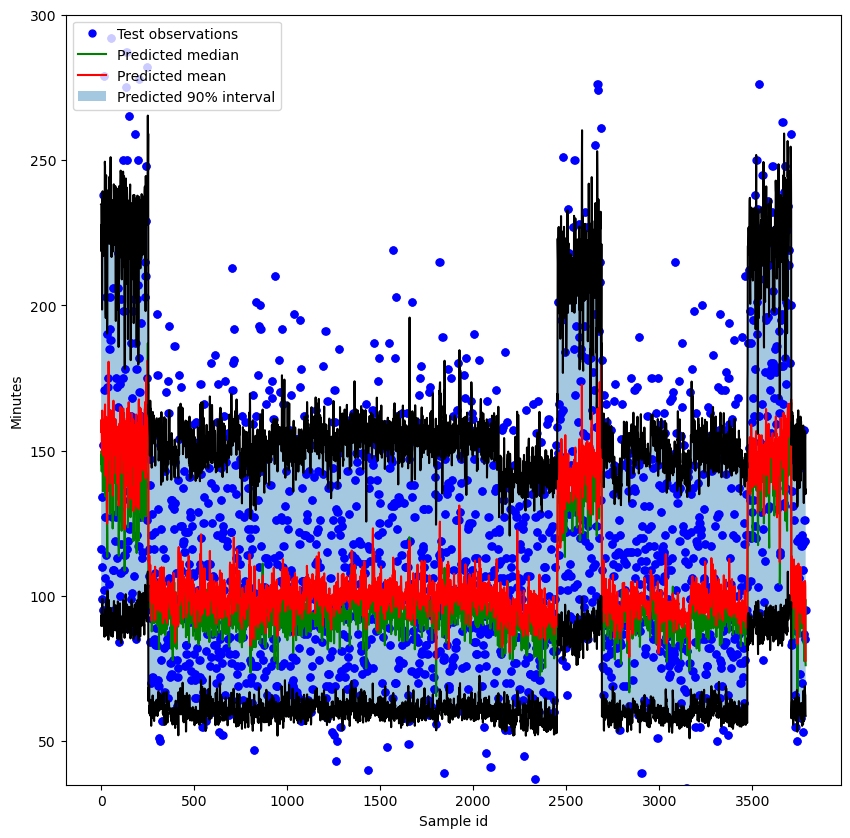

In [27]:
xx = np.arange(Xtest.shape[0])
fig = plt.figure(figsize=(10, 10))
#plt.plot(Xtest, f(Xtest), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(xx, ytest, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_med, "g-", label="Predicted median")
plt.plot(xx, ypred, "r-", label="Predicted mean")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("Sample id")
plt.ylabel("Minutes")
plt.ylim(35, 300)
plt.legend(loc="upper left")
plt.show()

In [ ]:
def get_model_by_data_category(train_data_subset, test_data_subset, subset_name, model_number_to_save=0):

    Xtrain, ytrain = preprocess_atp(train_data_subset)
    # Getting data weigths
    train_weights = get_train_weights(Xtrain, Lambda=1500)
    Xtrain = Xtrain.sort_values(by=['tourney_date']) # Warning: Necessary step for the Time Series cross-validation!
    Xtrain = Xtrain.drop(columns=['tourney_date'])

    columns_used_by_model = ['minutes'] + list(Xtrain.columns)
           
    Xtest, ytest = preprocess_atp(test_data_subset, is_atp_raw=True, train_df_columns=columns_used_by_model)
    if Xtest.shape[0] == 0:
        return [[], [], [], [], []]

    # Perform hyperparameter optimisation if necessary
    perform_Grid_Search = True
    if perform_Grid_Search:
        #todo: choose other hyperparameters
        
        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt', 3]
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
        max_depth.append(None)
        max_depth.append(5)
        #max_depth = [7]
        # Minimum number of samples required to split a node
        # min_samples_split = [2, 5, 10]
        min_samples_split = [5, 10, 20, 50, 100]
        # Minimum number of samples required at each leaf node
        # min_samples_leaf = [5, 20 , 50, 100]
        #min_samples_leaf = [51]
        # Create the random grid
        params = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    #'min_samples_leaf': min_samples_leaf,
                    }
        # Use the random grid to search for best hyperparameters
                
        #todo : probably 100 by default
        rf_regr = RandomForestRegressor()
        tscv = TimeSeriesSplit(n_splits=3, test_size=int(Xtest.shape[0]/2))
        rf_random_regr_cv = RandomizedSearchCV(rf_regr, params, scoring = "r2", n_iter = 10, cv = tscv, verbose=2, random_state=42, n_jobs = -1)
        # important hyperparameters are cv (for "Cross-Validation") and n_iter (number of combinations to test)
        # The chosen hyperpameters' values are quite low and should be higher for final model selection
        # rf_regr_cv = GridSearchCV(rf_regr, params, scoring="r2", n_jobs=-1, verbose=0, cv=10)
        rf_random_regr_cv.fit(Xtrain, ytrain, sample_weight=train_weights)
        print (f"Mean cross-validated score of the best_estimator: {rf_random_regr_cv.best_score_}")
        best_params = rf_random_regr_cv.best_params_
        
        
    else: 
        best_params = {'max_depth': 7, 'min_samples_leaf': 51}
    print (f"best parameters for the {subset_name} subset : {best_params}")

    # Fitting the Regressor
    rf_regr = RandomForestRegressor(**best_params, random_state=42)
    # from sklearn.svm import SVR
    # from sklearn.pipeline import make_pipeline
    # from sklearn.preprocessing import StandardScaler
    # rf_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    # rf_regr.fit(Xtrain, ytrain)

    rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)
    # weights should be a list of len len(ytrain)

    # Testing and Computing scores:
    ypred = rf_regr.predict(Xtest)
    ypred_train = rf_regr.predict(Xtrain)
    print(f"Training score : ", rf_regr.score(Xtrain, ytrain))
    print(f"Testing score : ", rf_regr.score(Xtest, ytest))
    print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))

    save_model = model_number_to_save != 0
    if save_model:
        
        path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
        model_prefix = '\model_' + str(model_number_to_save) # is also model_folder_name
        if not os.path.exists(path_to_models + model_prefix):
            os.makedirs(path_to_models + model_prefix)
        
        joblib.dump(rf_regr, path_to_models + model_prefix + model_prefix + '_' + str(subset_name))
    
    return ypred, ytest, ypred_train, ytrain, train_weights

#test_scores.append(rf_regr.score(Xtest, ytest))
#predictions.append(custom_predict(dtr, scale_x, scale_y, ht, a, rk, c, s, bo, h, l, r))   # ???



In [8]:
from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# rf_regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
# rf_regr.fit(Xtrain, ytrain)

def get_model_by_data_category_SVR(train_data_subset, test_data_subset, subset_name, model_number_to_save=0):

    # TODO: NORMALIZE DATA!!!
    Xtrain, ytrain = preprocess_atp(train_data_subset, scale_x=True)
    # Getting data weigths
    train_weights = get_train_weights(Xtrain, Lambda=1500)
    Xtrain = Xtrain.sort_values(by=['tourney_date']) # Warning: Necessary step for the Time Series cross-validation!
    Xtrain = Xtrain.drop(columns=['tourney_date'])

    columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
    Xtest, ytest = preprocess_atp(test_data_subset, is_atp_raw=True, train_df_columns=columns_used_by_model, scale_x=True)
    if Xtest.shape[0] == 0:
        return [[], [], [], [], []]

    # Perform hyperparameter optimisation if necessary
    perform_Grid_Search = True
    perform_Grid_Search = (subset_name == 'best_of_3')
    if perform_Grid_Search:
        
        # Create the random grid
        params = {"C": [1e-1, 1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-4, 2, 7)}
        # Use the random grid to search for best hyperparameters
        rf_regr = SVR(kernel="rbf")
        tscv = TimeSeriesSplit(n_splits=3, test_size=Xtest.shape/2)
        rf_random_regr_cv = RandomizedSearchCV(rf_regr, params, scoring = "r2", n_iter = 15, cv = tscv, verbose=2, random_state=42, n_jobs = -1)
        # important hyperparameters are cv (for "Cross-Validation") and n_iter (number of combinations to test)
        # The chosen hyperpameters' values are quite low and should be higher for final model selection
        # rf_regr_cv = GridSearchCV(rf_regr, params, scoring="r2", n_jobs=-1, verbose=0, cv=10)
        rf_random_regr_cv.fit(Xtrain, ytrain, sample_weight=train_weights)
        print (f"Mean cross-validated score of the best_estimator: {rf_random_regr_cv.best_score_}")
        best_params = rf_random_regr_cv.best_params_
        
        
    else: 
        best_params = {'gamma': 10.0, 'C': 1000.0}
    print (f"best parameters for the {subset_name} subset : {best_params}")

    # Fitting the Regressor
    rf_regr = SVR(kernel="rbf", **best_params)
    rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights)
    # weights should be a list of len len(ytrain)

    # Testing and Computing scores:
    ypred = rf_regr.predict(Xtest)
    ypred_train = rf_regr.predict(Xtrain)
    print(f"Training score : ", rf_regr.score(Xtrain, ytrain))
    print(f"Testing score : ", rf_regr.score(Xtest, ytest))
    print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))

    save_model = model_number_to_save != 0
    if save_model:
        
        path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
        model_prefix = '\model_' + str(model_number_to_save) # is also model_folder_name
        if not os.path.exists(path_to_models + model_prefix):
            os.makedirs(path_to_models + model_prefix)
        
        joblib.dump(rf_regr, path_to_models + model_prefix + model_prefix + '_' + str(subset_name))
    
    return ypred, ytest, ypred_train, ytrain, train_weights

#test_scores.append(rf_regr.score(Xtest, ytest))
#predictions.append(custom_predict(dtr, scale_x, scale_y, ht, a, rk, c, s, bo, h, l, r))   # ???


In [12]:
# testing set until 07.11:
#atp_test = atp_test[atp_test['tourney_date'] > 20220801] # keeping rows that are not in the training test
# testing set until 17.11:
# atp_test_old = pd.read_csv("ATP_matches/atp_matches_2022.csv")
# atp_test_old = atp_test_old[atp_test_old['tourney_date'] > 20220111] # keeping rows that are not in the training test
# The first date actually is "20220117"

# testing set after 17.11:
atp_all_players = pd.read_csv("atp_cat.csv")
max_tourney_date = max(atp_all_players['tourney_date'])
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]

ypred_all = []
ytest_all = []
ypred_train_all = []
ytrain_all = []

best_of_list = [5, 3]
# surface_type_list = ['Hard', 'Carpet', 'Clay', 'Grass']
surface_type_list = ['Hard', 'Clay', 'Grass']

# Part used to determine if we want to store the model
save_model = True
if save_model:
    path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
    model_number = len(os.listdir(path_to_models))
else:
    model_number = 0

# Splitting the data into different sets
for row, best_of in enumerate(best_of_list):
    for col, surface_type in enumerate(surface_type_list):
        subset_name = 'best_of_' + str(best_of) + '_' + str(surface_type)
        
        ATP_train_subset = atp_all_players[atp_all_players['best_of'] == best_of]
        ATP_train_subset = ATP_train_subset[ATP_train_subset['surface'] == surface_type]

        ATP_test_subset = atp_test[atp_test['best_of'] == best_of]
        ATP_test_subset = ATP_test_subset[ATP_test_subset['surface'] == surface_type]
        
        if ATP_test_subset.shape[0] == 0 or ATP_train_subset.shape[0] ==0:
            print(f"best of {best_of} and {surface_type} surface led to empty Dataframe")
        else:
            ypred, ytest, ypred_train, ytrain, train_weights = get_model_by_data_category_log_reg(ATP_train_subset, ATP_test_subset, subset_name, model_number)
            
            if len(ypred) >0:
                ypred_all += list(ypred)
                ytest_all += list(ytest.T[0])
                ypred_train_all += list(ypred_train)
                ytrain_all += list(ytrain.T[0])
        
ypred = np.array(ypred_all)
ytest = np.array(ytest_all)
ypred_train = np.array(ypred_train_all)
ytrain = np.array(ytrain_all)

print(f"Training score : ", r2_score(ytrain, ypred_train))
print(f"Testing score : ", r2_score(ytest, ypred))
#print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))


best parameters for the best_of_5_Hard subset : {'max_depth': 7, 'min_samples_leaf': 51}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training score :  0.01525614260478561
Testing score :  0.0
best parameters for the best_of_5_Grass subset : {'max_depth': 7, 'min_samples_leaf': 51}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training score :  0.015550618851158363
Testing score :  0.008333333333333333
best parameters for the best_of_3_Hard subset : {'max_depth': 7, 'min_samples_leaf': 51}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training score :  0.016862102038922064
Testing score :  0.010608203677510608
best parameters for the best_of_3_Clay subset : {'max_depth': 7, 'min_samples_leaf': 51}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training score :  0.01709439462873802
Testing score :  0.012598425196850394
best parameters for the best_of_3_Grass subset : {'max_depth': 7, 'min_samples_leaf': 51}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training score :  0.022399150743099786
Testing score :  0.0053475935828877
Training score :  -0.19711871939376735
Testing score :  -0.4733617206369236


d:\Anaconda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Using 6 subsets with a logistic regression.

# testing set until 07.11:
#atp_test = atp_test[atp_test['tourney_date'] > 20220801] # keeping rows that are not in the training test
# testing set until 17.11:
# atp_test_old = pd.read_csv("ATP_matches/atp_matches_2022.csv")
# atp_test_old = atp_test_old[atp_test_old['tourney_date'] > 20220111] # keeping rows that are not in the training test
# The first date actually is "20220117"

# testing set after 17.11:
atp_all_players = pd.read_csv("atp_cat.csv")
max_tourney_date = max(atp_all_players['tourney_date'])
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]

ypred_all = []
ytest_all = []
ypred_train_all = []
ytrain_all = []

best_of_list = [5, 3]
# surface_type_list = ['Hard', 'Carpet', 'Clay', 'Grass']
surface_type_list = ['Hard', 'Clay', 'Grass']

# Part used to determine if we want to store the model
save_model = True
if save_model:
    path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
    model_number = len(os.listdir(path_to_models))
else:
    model_number = 0

# Splitting the data into different sets
for row, best_of in enumerate(best_of_list):
    for col, surface_type in enumerate(surface_type_list):
        subset_name = 'best_of_' + str(best_of) + '_' + str(surface_type)
        
        ATP_train_subset = atp_all_players[atp_all_players['best_of'] == best_of]
        ATP_train_subset = ATP_train_subset[ATP_train_subset['surface'] == surface_type]

        ATP_test_subset = atp_test[atp_test['best_of'] == best_of]
        ATP_test_subset = ATP_test_subset[ATP_test_subset['surface'] == surface_type]
        
        if ATP_test_subset.shape[0] == 0 or ATP_train_subset.shape[0] ==0:
            print(f"best of {best_of} and {surface_type} surface led to empty Dataframe")
        else:
            ypred, ytest, ypred_train, ytrain, train_weights = get_model_by_data_category(ATP_train_subset, ATP_test_subset, subset_name, model_number)
            
            if len(ypred) >0:
                ypred_all += list(ypred)
                ytest_all += list(ytest.T[0])
                ypred_train_all += list(ypred_train)
                ytrain_all += list(ytrain.T[0])
        
ypred = np.array(ypred_all)
ytest = np.array(ytest_all)
ypred_train = np.array(ypred_train_all)
ytrain = np.array(ytrain_all)

print(f"Training score : ", r2_score(ytrain, ypred_train))
print(f"Testing score : ", r2_score(ytest, ypred))
#print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))


In [9]:
# Using 2 subsets instead of 6

# testing set until 07.11:
#atp_test = atp_test[atp_test['tourney_date'] > 20220801] # keeping rows that are not in the training test
# testing set until 17.11:
# atp_test_old = pd.read_csv("ATP_matches/atp_matches_2022.csv")
# atp_test_old = atp_test_old[atp_test_old['tourney_date'] > 20220111] # keeping rows that are not in the training test
# The first date actually is "20220117"

# testing set after 17.11:
atp_all_players = pd.read_csv("atp_cat.csv")
max_tourney_date = max(atp_all_players['tourney_date'])
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]

ypred_all = []
ytest_all = []
ypred_train_all = []
ytrain_all = []

best_of_list = [5, 3]

# Part used to determine if we want to store the model
save_model = True
if save_model:
    path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
    model_number = len(os.listdir(path_to_models))
else:
    model_number = 0

# Splitting the data into different sets
for row, best_of in enumerate(best_of_list):
    
    subset_name = 'best_of_' + str(best_of)
    
    ATP_train_subset = atp_all_players[atp_all_players['best_of'] == best_of]
    ATP_test_subset = atp_test[atp_test['best_of'] == best_of]
    
    if ATP_test_subset.shape[0] == 0 or ATP_train_subset.shape[0] ==0:
        print(f"best of {best_of} and led to empty Dataframe")
    else:
        #ypred, ytest, ypred_train, ytrain, train_weights = get_model_by_data_category(ATP_train_subset, ATP_test_subset, subset_name, model_number)
        ypred, ytest, ypred_train, ytrain, train_weights = get_model_by_data_category_SVR(ATP_train_subset, ATP_test_subset, subset_name, model_number)
        
        
        if len(ypred) >0:
            ypred_all += list(ypred)
            ytest_all += list(ytest.T[0])
            ypred_train_all += list(ypred_train)
            ytrain_all += list(ytrain.T[0])
    
ypred = np.array(ypred_all)
ytest = np.array(ytest_all)
ypred_train = np.array(ypred_train_all)
ytrain = np.array(ytrain_all)

print(f"Training score : ", r2_score(ytrain, ypred_train))
print(f"Testing score : ", r2_score(ytest, ypred))
#print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))


Scaling X...
Scaling X...
best parameters for the best_of_5 subset : {'gamma': 10.0, 'C': 1000.0}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training score :  0.8081627169249741
Testing score :  -0.08896355468128148
Balanced Training score :  0.9804510553040734
Scaling X...
Scaling X...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


d:\Anaconda\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean cross-validated score of the best_estimator: -0.10581148676121921
best parameters for the best_of_3 subset : {'gamma': 10.0, 'C': 100.0}


d:\Anaconda\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training score :  0.3690985045884755
Testing score :  -0.12391284460359064
Balanced Training score :  0.7798614530641085
Training score :  0.6336816390484094
Testing score :  0.15265856804734412


# Instantiate models

In [13]:
# Getting the data used with instantiated models (no additional features)

# testing set until 07.11:
#atp_test = atp_test[atp_test['tourney_date'] > 20220801] # keeping rows that are not in the training test
# testing set until 17.11:
# atp_test_old = pd.read_csv("ATP_matches/atp_matches_2022.csv")
# atp_test_old = atp_test_old[atp_test_old['tourney_date'] > 20220111] # keeping rows that are not in the training test
# The first date actually is "20220117"

# testing set after 17.11:
atp_all_players = pd.read_csv("atp_cat.csv")
max_tourney_date = max(atp_all_players['tourney_date'])
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]
Xtrain, ytrain = preprocess_atp(atp_all_players)
# Getting data weigths
train_weights = get_train_weights(Xtrain, Lambda=1500)
Xtrain = Xtrain.drop(columns=['tourney_date'])

columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
Xtest, ytest = preprocess_atp(atp_test, is_atp_raw=True, train_df_columns=columns_used_by_model)

In [73]:
# Getting the data used with instantiated models (with additional features)
atp = pd.read_csv("atp_cat_for_hist_features_calculation_lambda_250_2010.csv")
# df_final_additional_features = pd.read_csv("hist_features_lambda_250_2010_1_csv.csv", sep=';')
df_final_additional_features = pd.read_csv("hist_features_lambda_250_2010_1_csv.csv", decimal=',')
df_final_additional_features = df_final_additional_features.drop(["Unnamed: 0"], axis = 1)
df_final_additional_features = df_final_additional_features.set_index('original_match_idx')
completed_atp = atp.join(df_final_additional_features) # adding additional features to atp.
completed_atp = completed_atp.rename(columns={'player_aces_frequency':'diff_aces_frequency', 'player_double_fault_frequency':'diff_double_fault_frequency',
                        'player_serve_won_frequency':'diff_serve_won_frequency', 'player_points_won_frequency':'diff_points_won_frequency', 
                        'player_completeness':'diff_completeness',
                        'player_advantage_on_serve':'diff_advantage_on_serve'})
completed_atp = completed_atp.drop(["Unnamed: 0"], axis = 1)
atp_all_players = completed_atp.copy()

validation_instead_of_test = False
if validation_instead_of_test:
    max_tourney_date = get_former_year_date(max(atp_all_players['tourney_date'])) # Validation set instead of test set
else:
    max_tourney_date = max(atp_all_players['tourney_date']) # parameter 
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
if validation_instead_of_test:
    atp_test = atp_test[atp_test['tourney_date'] <= max_tourney_date]
# Filling missing values with random existing data.
# We decided to avoid using mean values in order to reduce the bias induced by the chosen filling method.
atp_test.sample(frac=1, random_state=42)
atp_test = atp_test.fillna(method="ffill")
atp_test = atp_test.fillna(method="bfill")

#todo: handle Nan values for the test set.

atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]
atp_all_players = atp_all_players.dropna() # Handling Nan values for the training set.
atp_all_players = atp_all_players.sort_values(by=["Sipko_uncertainty"])
final_atp_size = int(atp_all_players.shape[0]*0.85)
atp_all_players = atp_all_players.head(final_atp_size)
atp_all_players.sort_values(by=["tourney_date"])


# Preprocessing train data
Xtrain, ytrain = preprocess_atp(atp_all_players)
# Getting data weigths
train_weights = get_train_weights(Xtrain, Lambda=250)
Xtrain = Xtrain.drop(columns=['tourney_date'])

# Preprocessing test data
columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
Xtest, ytest = preprocess_atp(atp_test, is_atp_raw=True, train_df_columns=columns_used_by_model)

In [70]:
path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
rf_regr = joblib.load(path_to_models + "\model_31")

# Display Model's results

In [74]:
ypred_train = rf_regr.predict(Xtrain)
ypred = rf_regr.predict(Xtest)
print(f"Training score : ", rf_regr.score(Xtrain, ytrain))
print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))
print(f"Testing score : ", rf_regr.score(Xtest, ytest))

Training score :  0.3037184271380132
Balanced Training score :  0.3672042216012408
Testing score :  0.2728778136023383


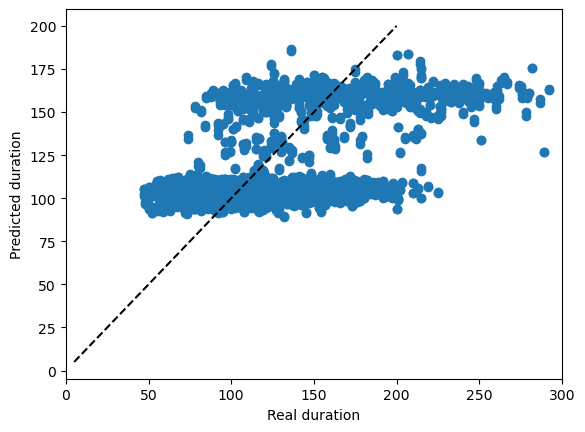

In [75]:
# Plot predicted duration without error bars 
# Most recent model

plt.scatter(ytest, ypred)
plt.plot([5, 200], [5, 200], 'k--')
plt.xlabel('Real duration')
plt.ylabel('Predicted duration')
plt.xlim((0, 300))
plt.show()

In [47]:
import time
import numpy as np

start_time = time.time()
importances = rf_regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_regr.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.061 seconds


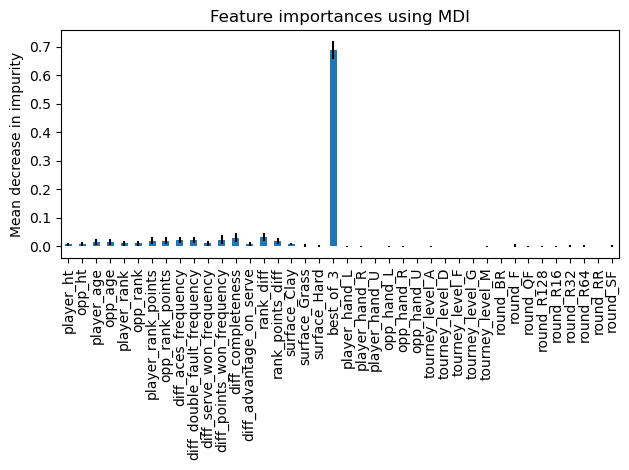

In [48]:
feature_names = list(Xtrain.columns)
# feature_names = [f"feature {i}" for i in range(Xtrain.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

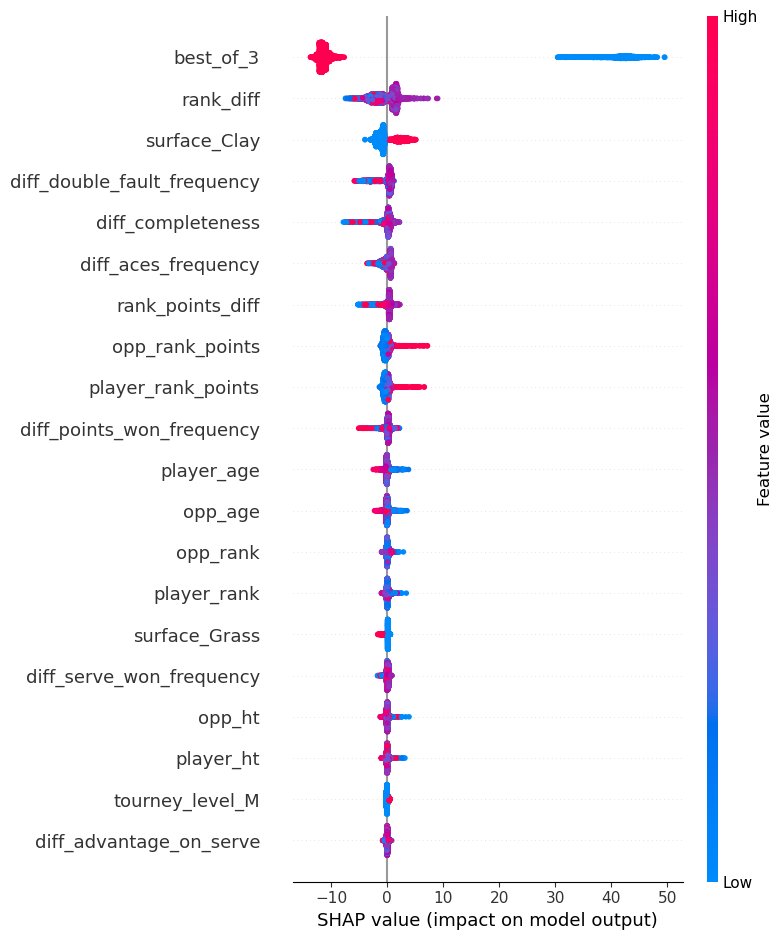

In [44]:
# Shap plot
import shap

explainer = shap.TreeExplainer(rf_regr)
shap_values = explainer.shap_values(Xtest)
shap.summary_plot(shap_values, Xtest)

In [76]:
def get_interval_score_rf(ypred, ytest, interval_size=20):
    ytest_bis = ytest.reshape(-1,)
    correct_pred = np.abs(ypred-ytest_bis) <= interval_size//2
    interval_score = np.count_nonzero(correct_pred)/len(correct_pred)
    return interval_score


In [78]:
minutes_error = []
correct_date_percentage = []
for i in range(10,40,10):
    
    print(f"plus ou moins {i} minutes: {round((get_interval_score_rf(ypred, ytest, interval_size=i*2)),3) *100}%")
    minutes_error.append(i)
    correct_date_percentage.append(round((get_interval_score_rf(ypred, ytest, interval_size=i*2)),3) *100)
    

plus ou moins 10 minutes: 20.1%
plus ou moins 20 minutes: 40.2%
plus ou moins 30 minutes: 58.9%


In [48]:
def get_confidence_score_rf(match_data, rf_regr, interval_size=20):
    """_summary_

    Args:
        match_data (1-row Dataframe): single sample match from Xtest
        rf_regr (sklearn.ensemble._forest.RandomForestRegressor)
        interval_size (int, optional): number of minutes in the interval.
    """
    if match_data.shape[1] != Xtest.shape[1]:
        print("given match does not have expected size (two few or too many features")
        return
    else:
        trees_predictions = []
        n_correct_trees = 0
        n_trees_total = rf_regr.n_estimators
        
        rf_prediction = rf_regr.predict(match_data)[0]
        for tree in rf_regr.estimators_:
            tree_prediction = tree.predict(match_data)[0]
            trees_predictions.append(tree_prediction)
            if abs(tree_prediction-rf_prediction) <= interval_size//2:
                n_correct_trees += 1
        prediction_score = n_correct_trees/n_trees_total
        return prediction_score, rf_prediction, trees_predictions

match_data = Xtest.iloc[[0]]
prediction_score, rf_prediction, trees_predictions = get_confidence_score_rf(match_data, rf_regr, interval_size=20)
actual_duration = ytest[0][0]
print (f"{rf_prediction} minutes estimated for the first match. Actual duration is {actual_duration}")
print(f"prediction score for the first match: {prediction_score}")


154.90438972243422 minutes estimated for the first match. Actual duration is 116.0
prediction score for the first match: 0.94


d:\Anaconda\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
d:\Anaconda\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Anaconda\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Anaconda\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Anaconda\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Anaconda\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without featu

# Partie Dérivant d'un notebook du projet précédant:

TypeError: unsupported operand type(s) for /: 'float' and 'builtin_function_or_method'

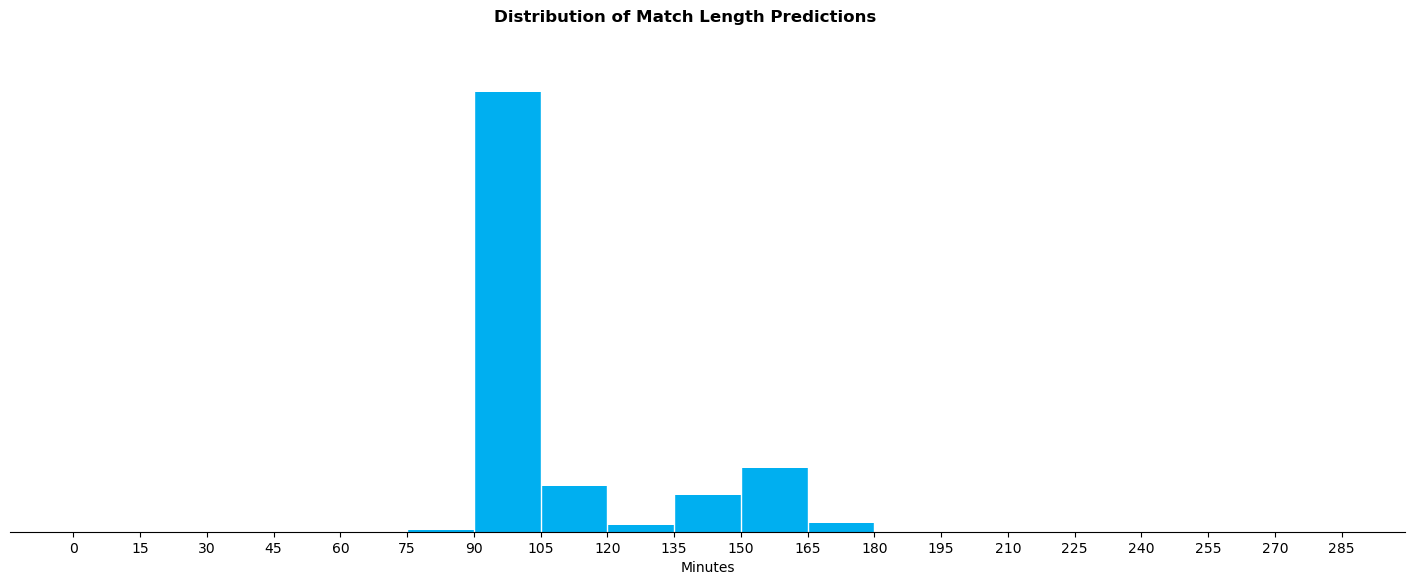

In [21]:
### HISTOGRAM ###

# ATP Colors
# Dark blue : #002865
# Light blue : #00AFF0
# Rolland Garros Orange : #CB5A19
# Tennis Ball Yellow : #8CFF00

time_step = 15  # precision : 15/20/30 minutes

def plot_distribution(time_step) : 
    
    fig, ax = plt.subplots(1, figsize=(18,6))

    #plt.suptitle(f'Distribution of Match Length Predictions : {PLAYER1} v. {PLAYER2}', fontweight='bold')
    plt.suptitle(f'Distribution of Match Length Predictions', fontweight='bold')
    plt.xlabel("Minutes")
    # plt.ylabel("Nb of predictions")

    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.yticks([])
    
    
    intervals=np.arange(0, 300, time_step)
    n, bins, patches = plt.hist(predictions, bins=intervals, color='#00AFF0')

    plt.xticks(bins)
    plt.grid(color='white', lw = 1, axis='x')

    xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]

    for idx, value in enumerate(n) :
        if value > 0 :
            plt.text(xticks[idx], value * 1.05, f"{int(100 * value / iter)}%", ha='center')
            plt.text(xticks[idx], value / 2, int(value), ha='center', color='w', fontweight='semibold')
        
    if (average_prediction >= 0) : plt.axvline(x=average_prediction, color='#CB5A19')
    # plt.axvline(x=116, color='#8CFF00')
    # plt.legend()


    plt.show()

plot_distribution(time_step)


In [ ]:
### CUSTOM PREDICTION ###

def custom_predict(dtr, scale_x, scale_y, height, age, rank_diff, consecutive, surface, best_of, hand, level, round) :
    # returns the predicted length of a match given a set of match conditions

    # surface : clay(1), grass(2), hard(3)
    # best of : 3(1), 5(2)
    # hand : left(1), right(2)
    # level : A(1), D(2), G(3), M(4)
    # round : F(1), QF(2), R128(3), R16(4), R32(5), R64(6), R(7), SF(8)

    surface_input = [0, 0, 0]
    surface_input[surface - 1] = 1

    bo_input = [0, 0]
    bo_input[best_of - 1] = 1

    hand_input = [0, 0]
    hand_input[hand - 1] = 1

    level_input = [0, 0, 0]
    level_input[level - 1] = 1

    round_input = [0, 0, 0, 0, 0, 0, 0, 0]
    round_input[round - 1] = 1

    X_custom = pd.DataFrame(columns=X.columns)


    if (not scale_x and not scale_y) :  # 1. X, y unscaled
        input = [height, age, rank_diff] + [consecutive] + surface_input + bo_input + hand_input + level_input + round_input
        X_custom = pd.DataFrame(columns=X.columns)
        print(input)
        X_custom.loc[0] = input
        display(X_custom)

        print("Prediction : ", dtr.predict(X_custom), " minutes")

        return(dtr.predict(X_custom)[0])

    elif (scale_x and scale_y) :    # 2. X, y scaled
        input = xscaler.transform([[height, age, rank_diff]])
        print(input)
        input = np.append(input[0], [consecutive] + surface_input + bo_input + hand_input + level_input + round_input)

        X_custom.loc[0] = input
        # print("Scaled input : ")
        # display(X_custom)

        print("Scaled Prediction : ", dtr.predict(X_custom), " minutes")
        print("Prediction : ", yscaler.inverse_transform(dtr.predict(X_custom)), " minutes")

        return(yscaler.inverse_transform(dtr.predict(X_custom))[0])

    elif (scale_x and not scale_y) :    # 3. X scaled, y unscaled
        input = xscaler.transform([[height, age, rank_diff]]).tolist()
        input = np.append(input[0], [consecutive] + surface_input + bo_input + hand_input + level_input + round_input)

        X_custom.loc[0] = input
        # print("Scaled input : ")
        # display(X_custom)

        print("Prediction : ", dtr.predict(X_custom)[0], " minutes")

        return(dtr.predict(X_custom)[0])


# e.g. custom_predict(dtr, scale_x, scale_y, 180, 22, 0, 0, 4, 1, 2, 4, 5)

In [ ]:
### TREE VISUALIZATION ###

from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

def visualize_tree(dtr) :

    features = list(player1.columns)
    features.remove("minutes")

    dot_data = StringIO()
    export_graphviz(dtr, out_file=dot_data, feature_names=features, filled=True)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph[0].create_png()))

In [ ]:
### INTERFACE ###

# Validate Button

button = widgets.Button(description="Confirm")

out1 = widgets.Output()

display(button, out1)



# Match Settings

match_settings_title = widgets.Label(value='MATCH CONDITIONS')

surface_radio = widgets.RadioButtons(
    options=['Hard', 'Grass', 'Clay'],
    description='Surface',
    disabled=False
)

best_of_radio = widgets.RadioButtons(
    options=['3', '5'],
    description='Best of',
    disabled=False
)

level_dropdown = widgets.Dropdown(
    description="Level",
    options=['Grand Slam (G)', 'Masters 1000s (M)', 'Other (A)']
)

round_dropdown = widgets.Dropdown(
    description="Round",
    options=['Final', 'Semifinals', 'Quarterfinals', 'R16', 'R32', 'R64', 'R128', 'R']
)

match_inputs_1 = widgets.HBox([surface_radio, best_of_radio])
match_inputs_2 = widgets.HBox([level_dropdown, round_dropdown])

# Players

player1_title = widgets.Label(value='PLAYER 1')

player1_text = widgets.Text(value=PLAYER1, placeholder="Player 1", description='Name')

player1_height_display = widgets.Text(description='Height')
player1_hand_display = widgets.Text(description='Hand')
player1_rank_display = widgets.Text(description='Rank')
player1_age_display = widgets.Text(description='Age')
player1_cons_display = widgets.Text(description='Win streak')

if (pd.notna(atp_players.loc[atp_players.name==PLAYER1, 'height'].values[0])) :
    player1_height_display.value = str(atp_players.loc[atp_players.name==PLAYER1, 'height'].values[0])
else :
    player1_height_display.value = '185'
player1_hand_display.value = str(atp_players.loc[atp_players.name==PLAYER1, 'hand'].values[0])
player1_rank_display.value = str(atp_players.loc[atp_players.name==PLAYER1, 'rank'].values[0])
player1_age_display.value = '25'
player1_cons_display.value = '0'

player1_widgets = widgets.VBox([player1_title, player1_text, player1_height_display, player1_hand_display, player1_rank_display, player1_age_display, player1_cons_display])


player2_title = widgets.Label(value='PLAYER 2')

player2_text = widgets.Text(value=PLAYER2, placeholder="Player 2", description='Name')

player2_height_display = widgets.Text(description='Height')
player2_hand_display = widgets.Text(description='Hand')
player2_rank_display = widgets.Text(description='Rank')
player2_age_display = widgets.Text(description='Age')
player2_cons_display = widgets.Text(description='Win streak')

if (pd.notna(atp_players.loc[atp_players.name==PLAYER2, 'height'].values[0])) :
    player2_height_display.value = str(atp_players.loc[atp_players.name==PLAYER2, 'height'].values[0])
else :
    player2_height_display.value = '185'
player2_hand_display.value = str(atp_players.loc[atp_players.name==PLAYER2, 'hand'].values[0])
player2_rank_display.value = str(atp_players.loc[atp_players.name==PLAYER2, 'rank'].values[0])
player2_age_display.value = '25'
player2_cons_display.value = '0'

player2_widgets = widgets.VBox([player2_title, player2_text, player2_height_display, player2_hand_display, player2_rank_display, player2_age_display, player2_cons_display])


player_inputs = widgets.HBox([player1_widgets, player2_widgets])

display(match_settings_title, match_inputs_1, match_inputs_2)
display(player_inputs)
print("(Optional) For better precision, input player age and win streak.")



### BEHAVIOR ###

def validate(b):
    global PLAYER1
    global PLAYER2
    out1.clear_output()
    if (def_player1_text.value in atp_players.name.values) and (def_player2_text.value in atp_players.name.values) :
        with out1 :
            print("Valid players.")
        PLAYER1 = def_player1_text.value
        player1_text.value = PLAYER1
        PLAYER2 = def_player2_text.value
        player2_text.value = PLAYER2
    else :
        with out1 :
            print("Invalid players. Try again.")

button.on_click(validate)

def player1_eventhandler(change):
    global PLAYER1
    if change.new in atp_players.name.values :
        PLAYER1 = change.new
        if (pd.notna(atp_players.loc[atp_players.name==PLAYER1, 'height'].values[0])) :
            player1_height_display.value = str(atp_players.loc[atp_players.name==PLAYER1, 'height'].values[0])
        else :
            player1_height_display.value = '185'
        player1_hand_display.value = str(atp_players.loc[atp_players.name==PLAYER1, 'hand'].values[0])
        player1_rank_display.value = str(atp_players.loc[atp_players.name==PLAYER1, 'rank'].values[0])
        
def player2_eventhandler(change):
    global PLAYER2
    if change.new in atp_players.name.values :
        PLAYER2 = change.new
        if (pd.notna(atp_players.loc[atp_players.name==PLAYER2, 'height'].values[0])) :
            player2_height_display.value = str(atp_players.loc[atp_players.name==PLAYER2, 'height'].values[0])
        else :
            player2_height_display.value = '185'
        player2_hand_display.value = str(atp_players.loc[atp_players.name==PLAYER2, 'hand'].values[0])
        player2_rank_display.value = str(atp_players.loc[atp_players.name==PLAYER2, 'rank'].values[0])

player1_text.observe(player1_eventhandler, names='value')
player2_text.observe(player2_eventhandler, names='value')

Button(description='Confirm', style=ButtonStyle())

Output()

Label(value='MATCH CONDITIONS')

(Optional) For better precision, input player age and win streak.


In [ ]:
# Converting the user inputs into inputs usable by the custom_predict function

sd = { 'Clay':1, 'Grass':2, 'Hard':3 }                                                                  # Surface dictionary
bod = { '3':1, '5':2 }                                                                                  # Best of dictionary
hd = { 'L':1, 'R':2 }                                                                                   # Hand dictionary
ld = { 'Other (A)':1, 'Grand Slam (G)':2, 'Masters 1000s (M)':3 }    # Level dictionary
rd = { 'Final':1, 'Quarterfinals':2, 'R128':3, 'R16':4, 'R32':5, 'R64':6, 'R':7, 'Semifinals':8 }       # Round dictionary

def t2i(dict, text) :   # text to input
    return dict[text]

ht = float(player2_height_display.value)
a = float(player2_age_display.value)
rk = float(player1_rank_display.value) - float(player2_rank_display.value)
c = int(player1_cons_display.value)
s = t2i(sd, surface_radio.value)
bo = int(t2i(bod, best_of_radio.value))
h = t2i(hd, player2_hand_display.value)
l = t2i(ld, level_dropdown.value)
r = t2i(rd, round_dropdown.value)

In [ ]:
### REGRESSION FOREST ###

test_scores = []
predictions = []
average_prediction = -1

iter = 10

# UI

iter_label = widgets.Label('Nb of trees')
iter_slider = widgets.IntSlider(value=iter, min=2, max=100)
iter_text = widgets.Text()
widgets.jslink((iter_slider, 'value'), (iter_text, 'value'))
iter_input = widgets.HBox([iter_label, iter_slider, iter_text])

loading_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=iter,
    bar_style='',
    orientation='horizontal'
)
loading_label = widgets.Label(value='Planting Trees...')
loading = widgets.HBox([loading_label, loading_bar])

# The Loop

def random_forest_loop() :
    
    global average_prediction

    for i in range(iter) :

        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.3)
        dtr_cv.fit(Xtrain, ytrain)

        best_params = dtr_cv.best_params_
        print(f"Best parameters: {best_params})")

        dtr = DecisionTreeRegressor(**best_params)
        dtr.fit(Xtrain, ytrain)

        # Testing :

        ypred = dtr.predict(Xtest)

        print(f"Training score {i+1} : ", dtr.score(Xtrain, ytrain))
        print(f"Testing score {i+1} : ", dtr.score(Xtest, ytest))
        test_scores.append(dtr.score(Xtest, ytest))

        predictions.append(custom_predict(dtr, scale_x, scale_y, ht, a, rk, c, s, bo, h, l, r))     # ???

        # visualize_tree(dtr)

        loading_bar.value += 1
        if (i==iter-1) :
            loading_bar.bar_style='success'


        print("------------------------------------------------------------------------------------------------")

    print("------------------------------------------------------------------------------------------------")
    print("Test scores : ", test_scores)
    print("Test scores average : ", sum(test_scores)/len(test_scores))

    average_prediction = sum(predictions) / len(predictions)

    print("------------------------------------------------------------------------------------------------")
    print(f"Predictions : {predictions}")
    print(f"Average predicted length : {average_prediction}")


launch_btn = widgets.Button(description='Plant Forest')

out2 = widgets.Output()

display(iter_input)
display(launch_btn)
display(out2)



### HISTOGRAM ###

# ATP Colors
# Dark blue : #002865
# Light blue : #00AFF0
# Rolland Garros Orange : #CB5A19
# Tennis Ball Yellow : #8CFF00

time_step = 15  # precision : 15/20/30 minutes

def plot_distribution(time_step) : 
    
    fig, ax = plt.subplots(1, figsize=(18,6))

    plt.suptitle(f'Distribution of Match Length Predictions : {PLAYER1} v. {PLAYER2}', fontweight='bold')
    plt.xlabel("Minutes")
    # plt.ylabel("Nb of predictions")

    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.yticks([])
    
    
    intervals=np.arange(0, 300, time_step)
    n, bins, patches = plt.hist(predictions, bins=intervals, color='#00AFF0')

    plt.xticks(bins)
    plt.grid(color='white', lw = 1, axis='x')

    xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]

    for idx, value in enumerate(n) :
        if value > 0 :
            plt.text(xticks[idx], value * 1.05, f"{int(100 * value / iter)}%", ha='center')
            plt.text(xticks[idx], value / 2, int(value), ha='center', color='w', fontweight='semibold')
        
    if (average_prediction >= 0) : plt.axvline(x=average_prediction, color='#CB5A19')
    # plt.axvline(x=116, color='#8CFF00')
    # plt.legend()


    plt.show()

out3 = widgets.Output()
time_step_slider = widgets.IntSlider(value=time_step, min=5, max=45, step=5, description='Time Step')

with out3:
    plot_distribution(time_step)

def iter_slider_eventhandler(change) :
    global iter
    iter = change.new

def launch_btn_onclick(change) :
    out2.clear_output()
    loading_bar.max = iter
    with out2 : 
        display(loading)
    random_forest_loop()
    out3.clear_output()
    with out3:
        plot_distribution(time_step)

iter_slider.observe(iter_slider_eventhandler, names='value')
launch_btn.on_click(launch_btn_onclick)

def time_step_slider_eventhandler(change) :
    out3.clear_output()
    with out3:
        plot_distribution(change.new)

time_step_slider.observe(time_step_slider_eventhandler, names='value')

print("Drag slider to plot :")
display(time_step_slider, out3)

Button(description='Plant Forest', style=ButtonStyle())

Output()

Drag slider to plot :


IntSlider(value=15, description='Time Step', max=45, min=5, step=5)

Output()

Best parameters: {'max_depth': 4, 'min_samples_leaf': 62})
Training score 1 :  0.34822352710043436
Testing score 1 :  0.33216706935806994
[185.0, 25.0, 12.0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185.0,25.0,12.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prediction :  [104.37755102]  minutes
------------------------------------------------------------------------------------------------
Best parameters: {'max_depth': 4, 'min_samples_leaf': 71})
Training score 2 :  0.3350885794447769
Testing score 2 :  0.3490607259431744
[185.0, 25.0, 12.0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185.0,25.0,12.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prediction :  [106.27956989]  minutes
------------------------------------------------------------------------------------------------
Best parameters: {'max_depth': 5, 'min_samples_leaf': 58})
Training score 3 :  0.3717809413316939
Testing score 3 :  0.23665041332021464
[185.0, 25.0, 12.0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185.0,25.0,12.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prediction :  [98.5483871]  minutes
------------------------------------------------------------------------------------------------
Best parameters: {'max_depth': 5, 'min_samples_leaf': 25})
Training score 4 :  0.3943651602434781
Testing score 4 :  0.30396023762961455
[185.0, 25.0, 12.0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185.0,25.0,12.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prediction :  [84.41176471]  minutes
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
Test scores :  [0.33216706935806994, 0.3490607259431744, 0.23665041332021464, 0.30396023762961455]
Test scores average :  0.30545961156276835
------------------------------------------------------------------------------------------------
Predictions : [104.37755102040816, 106.27956989247312, 98.54838709677419, 84.41176470588235]
Average predicted length : 98.40431817888447


In [ ]:
reset_btn = widgets.Button(description="Reset")

def reset_click(change):
    global test_scores
    global predictions
    global average_prediction
    test_scores = []
    predictions = []
    average_prediction = -1
    
    out1.clear_output()
    out2.clear_output()
    out3.clear_output()
    
    
reset_btn.on_click(reset_click)

display(reset_btn)

Button(description='Reset', style=ButtonStyle())

In [ ]:
# !pip freeze > requirements.txt

# Manually registered data used to plot some of the curves

In [ ]:
# manually registered scores using shallow forest(max_depth=10), 250 lambdas for hist data calc and for data weights.

validation_score_list_1 = [0.25276636144490494,
 0.25566477657275166,
 0.2550791897832626,
 0.260831294987962,
 0.2635623301812321,
 0.26490603177014516,
 0.26821741898014406,
 0.2758502483971641,
 0.2794366318180146,
 0.28204030357001353,
 0.2779234034827429,
 0.2792492829800278]
uncertainty_treshold_list_1 = [0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1. ]

# validation_score_list_1 = [0.2635623301812321,
#  0.26490603177014516,
#  0.26821741898014406,
#  0.2758502483971641,
#  0.2794366318180146,
#  0.28204030357001353,
#  0.2779234034827429]
# uncertainty_treshold_list_1 = [0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ]


# Shallow forest(max_depth=7), 250 lambdas for hist data calc and for data weights.

validation_score_list_2 = [0.2563858271467391,
 0.2610308226250946,
 0.2602652349242137,
 0.25591660650111225,
 0.2590588583048079,
 0.25683556186147705,
 0.26425697152114624,
 0.2689918260329567,
 0.2663862556993709,
 0.2683437634121296,
 0.2717239793017725,
 0.27692084967637687,
 0.28173347687192896,
 0.2833756976725448,
 0.2790590544410605,
 0.2817865943624204,
 0.2817865943624204]
uncertainty_treshold_list_2 = [0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]

# # shallow forest (max_depth=10), 730 lambda for hist data calc and 250 for data weights
# validation_score_list_3 = [0.23316879510486266,
#  0.23796345006963115,
#  0.24943471432848396,
#  0.2495598149448246,
#  0.2507817850926629,
#  0.2500930750970253,
#  0.2514304976082602,
#  0.2551244855705863,
#  0.2657094962192209,
#  0.263596913892709,
#  0.2651691553189258,
#  0.2618682158676018,
#  0.27310549099012915,
#  0.2761039092807548,
#  0.2734404157171143,
#  0.27452365133296786,
#  0.27452365133296786]
# uncertainty_treshold_list_3 = [0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
#        0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]

# shallow forest (max_depth=7), 730 lambda for hist data calc and 250 for data weights
validation_score_list_4 = [0.23743077928177503,
 0.241010202406445,
 0.25290357060935886,
 0.25257798709532187,
 0.25482778500961545,
 0.2530572089998826,
 0.2559122672127506,
 0.2578373890017789,
 0.2693582016987611,
 0.2664727927229694,
 0.26945339244863453,
 0.2665159338484,
 0.27757446941996233,
 0.2800211350738052,
 0.27669838724336104,
 0.27759621193200656,
 0.27759621193200656]
uncertainty_treshold_list_4 = [0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95, 1.]



# deep forest, 730 lambda for hist data calc and for data weights
validation_score_list_5 = [0.2614789130458399,
 0.2681838707015396,
 0.27316175209917826,
 0.2683317827350624,
 0.26844588956858084,
 0.2669555788683773,
 0.2673651087527391,
 0.2689317459641961,
 0.27431285427487373,
 0.2728494677107307,
 0.2751036706574448,
 0.2733808717768247,
 0.27698445358373525,
 0.2765075818436713,
 0.2746664950342499,
 0.2756650226925923,
 0.2756650226925923]
uncertainty_treshold_list_5 = [0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]

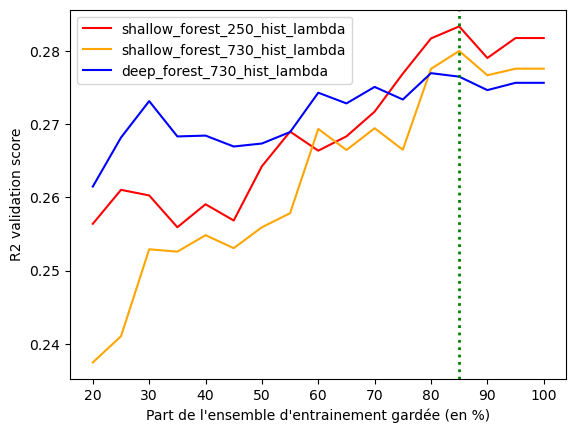

In [ ]:
plt.xlabel("Part de l'ensemble d'entrainement gardée (en %)")
# Set the y axis label of the current axis.
plt.ylabel('R2 validation score')
# Set a title 
# Display the figure.
plt.plot(np.round_(np.array(uncertainty_treshold_list_2)*100,  decimals = 0),validation_score_list_2, color='red',  label = 'shallow_forest_250_hist_lambda')
plt.plot(np.round_(np.array(uncertainty_treshold_list_4)*100,  decimals = 0),validation_score_list_4, color='orange',  label = 'shallow_forest_730_hist_lambda')
plt.plot(np.round_(np.array(uncertainty_treshold_list_5)*100,  decimals = 0),validation_score_list_5, color='blue',  label = 'deep_forest_730_hist_lambda')


plt.axvline(x=85, color='green', ls=':', lw=2)
#plt.axvline(x=730, color='green', ls=':', lw=2)
# show a legend on the plot
plt.legend()
plt.show()